# Report Execution Information on Different cluster Machines

This notebook benchmarks the **Harpia module**, the backend engine for Annotat3d, and similar frameworks on three machines from CNPEM cluster: Mary, Aida and Harriet.


## Framework

In [3]:
import os
import glob
import numpy as np
import pandas as pd
from pandas.plotting import table
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

def read_csv_files(path):
    # Get the current working directory
    print("Searching in:", path)

    # Recursively find all CSV files in subdirectories
    csv_files = glob.glob(os.path.join(path, "**", "*.csv"), recursive=True)

    if not csv_files:
        print("No CSV files found.")
        return None

    # Read all CSV files into a list of DataFrames
    #dfs = []
    #for file in csv_files:
    #    print(file)
    #    dfs.append(pd.read_csv(file))
    dfs = [pd.read_csv(file) for file in csv_files]

    # Optionally, concatenate all DataFrames into one
    df_all = pd.concat(dfs, ignore_index=True)

    print(f"Loaded {len(csv_files)} CSV files.")
    return df_all


In [4]:
def filter_dataframe(df, filters):
    """
    Filters the DataFrame based on the specified filters.

    Parameters:
    - df (pd.DataFrame): The DataFrame to filter.
    - filters (dict): A dictionary where the key is the column name and the value is the value to filter by.

    Returns:
    - pd.DataFrame: The filtered DataFrame (original remains unchanged).
    """
    filtered_df = df.copy()
    for col, value in filters.items():
        filtered_df = filtered_df[filtered_df[col] == value]
    return filtered_df


In [5]:
def save_df_as_image(df, filename='df_image.png', dpi=300, show_index=True):
    """
    Saves a DataFrame as a well-formatted image file.

    Parameters:
    - df (pd.DataFrame): The DataFrame to save.
    - filename (str): The output filename (PNG).
    - dpi (int): Resolution in dots per inch.
    - show_index (bool): Whether to display the index in the image. Default is True.
    """
   # Create a copy to avoid modifying the original DataFrame
    display_df = df.copy()
    
    # If the index should not be displayed, remove it
    if not show_index:
        display_df.index = [''] * len(display_df)
    
    # Determine the figure size based on DataFrame dimensions
    fig_width = min(20, max(6, 0.2 * display_df.shape[1]))  # Scale width by number of columns
    fig_height = min(40, max(4, 0.4 * display_df.shape[0])) # Scale height by number of rows
    
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.axis('off')  # Hide the axis
    mpl_table = table(ax, display_df, loc='center', cellLoc='center', colWidths=[0.2]*len(display_df.columns))
    
    # Formatting for better readability
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(10)
    mpl_table.auto_set_column_width(col=list(range(len(display_df.columns))))  # Auto-adjust column width
    
    # Remove extra padding around the table
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    
    # Get the bounding box of the table and adjust the figure size
    renderer = fig.canvas.get_renderer()
    bbox = mpl_table.get_window_extent(renderer=renderer)
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    
    # Save the image, tightly cropped to the table's exact size
    output_path = filename
    plt.savefig(output_path, bbox_inches=bbox, pad_inches=0, dpi=dpi)
    plt.close(fig)
    print(output_path)
    return output_path

In [7]:
def clean_framework_df(df, framework_name, min_input_size=0, min_input_mem=0):
    # Base columns common to all
    base_cols = ['Operation', 'Machine', 'Gpus', 'gpuMemory', 'Repetitions',
                 'Image Data Type', 'Image Size (MiB)', 'Image Dimensions']

    # Framework-specific time and GPU memory columns
    time_col_map = {
        'skimage': 'Scikit Time (s)',
        'harpia': 'Harpia Time (s)',
        'cucim': 'Cucim Total Time (s)'
    }

    gpu_cols_map = {
        'skimage': ['skimage_gpu0(MiB)', 'skimage_gpu1(MiB)', 'skimage_gpu2(MiB)'],
        'harpia':  ['harpia_gpu0(MiB)', 'harpia_gpu1(MiB)', 'harpia_gpu2(MiB)'],
        'cucim':   ['cucim_gpu0(MiB)',  'cucim_gpu1(MiB)',  'cucim_gpu2(MiB)']
    }

    # Always select the base and total time column
    selected_cols = base_cols + [time_col_map[framework_name]] + gpu_cols_map[framework_name]

    # Add cucim-specific extra time columns
    if framework_name == 'cucim':
        selected_cols += ['Cucim Memory Time (s)', 'Cucim Gpu Time (s)']

    df_clean = df[selected_cols].copy()

    # Rename main time column to unified name
    df_clean.rename(columns={time_col_map[framework_name]: 'Total Time (s)'}, inplace=True)

    # Rename GPU0 to GPU Before
    df_clean.rename(columns={gpu_cols_map[framework_name][0]: 'GPU Before (MiB)'}, inplace=True)

    if framework_name == 'cucim':
        df_clean.rename(columns={'Cucim Memory Time (s)': 'Memory Time (s)'}, inplace=True)
        df_clean.rename(columns={'Cucim Gpu Time (s)': 'Gpu Time (s)'}, inplace=True)
    
    # Calculate GPU Max from GPU1 and GPU2
    gpu1_col = gpu_cols_map[framework_name][1]
    gpu2_col = gpu_cols_map[framework_name][2]
    df_clean['GPU Max (MiB)'] = df_clean[gpu1_col].combine(df_clean[gpu2_col], func=max)

    # Drop original GPU1 and GPU2 columns
    df_clean.drop(columns=[gpu1_col, gpu2_col], inplace=True)

    # Set GPU memory columns to NaN if framework is skimage or image size <= 1000
    memory_mask = (framework_name == 'skimage') | (df_clean['Image Size (MiB)'] <= min_input_mem)
    df_clean.loc[memory_mask, ['GPU Before (MiB)', 'GPU Max (MiB)']] = float('nan')

    # Drop rows where all performance metrics are NaN
    df_clean.dropna(
        subset=['Total Time (s)', 'GPU Before (MiB)', 'GPU Max (MiB)'],
        how='all',
        inplace=True
    )

    # Drop rows with image size ≤ min_input_size
    df_clean = df_clean[df_clean['Image Size (MiB)'] > min_input_size]

    # Add framework column
    framework_name_map = {
        "harpia": "Harpia",
        "cucim": "cuCIM",
        "skimage": "scikit-image"
    }
    df_clean['Framework'] = framework_name_map[framework_name]

    return df_clean


In [8]:
def print_unique_values(df, columns):
    for col in columns:
        if col in df.columns:
            unique_vals = df[col].unique()
            print(f"\nColumn: {col}")
            print(f"Unique values ({len(unique_vals)}): {unique_vals}")
        else:
            print(f"\nColumn: {col} not found in DataFrame.")


## Read data

In [9]:
current_dir = os.getcwd()
df_aida = read_csv_files(current_dir+"/results_aida/cython/")
df_cython = read_csv_files(current_dir+"/results_harriet/cython/")
df_mary = read_csv_files(current_dir+"/results_mary/")
df_harriet = df_cython.loc[df_cython['Machine']=='harriet']
df_notebook = df_cython.loc[df_cython['Machine']=='notebook']

Searching in: /ibira/lnls/labs/tepui/home/camila.araujo/work/harpia/tests_python/benchmark/results_aida/cython/
Loaded 11 CSV files.
Searching in: /ibira/lnls/labs/tepui/home/camila.araujo/work/harpia/tests_python/benchmark/results_harriet/cython/
Loaded 4 CSV files.
Searching in: /ibira/lnls/labs/tepui/home/camila.araujo/work/harpia/tests_python/benchmark/results_mary/
Loaded 156 CSV files.


## Save Results

In [10]:
notebook_name = "comp_report"
output_dir = f"{notebook_name}_plots"
os.makedirs(output_dir, exist_ok=True)
print(f"Plots will be saved to: {output_dir}")

Plots will be saved to: comp_report_new_plots


## Harriet

Removi tamanho de imagem pequneo demais, não havia dads significativos do scikit-image. Os dados da harriet não são muito confiáveis, eles trazem a média, mas não o desvio padrão. Difícil usá-los apra comparar com outras máquinas assim. Só tem os dados da Harpia também, não tem resultados do cuCIM

In [8]:
df_harriet.drop(columns=['Mean Squared Error', 'Pixel Accuracy (%)', 'Image Data Type', 'Time Ratio', 'Scikit-Image Time (s)'], inplace=True)
indices_to_drop = df_harriet[df_harriet['Image Dimensions'] == '(190, 207, 100)'].index
df_harriet.drop(indices_to_drop, inplace = True)
df_harriet

/tmp/ipykernel_149444/4082071957.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_harriet.drop(columns=['Mean Squared Error', 'Pixel Accuracy (%)', 'Image Data Type', 'Time Ratio', 'Scikit-Image Time (s)'], inplace=True)
/tmp/ipykernel_149444/4082071957.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_harriet.drop(indices_to_drop, inplace = True)


,Operation,Machine,Gpus,gpuMemory,Module Time (s),Repetitions,Image Size (MB),Image Dimensions
0,Erosion 3D grayscale,harriet,1,0.1,18.212188,20,32896.1,"(2052, 2052, 2048)"
1,Dilation 3D grayscale,harriet,1,0.1,9.407168,20,32896.1,"(2052, 2052, 2048)"
2,Closing 3D grayscale,harriet,1,0.1,11.028709,20,32896.1,"(2052, 2052, 2048)"
3,Opening 3D grayscale,harriet,1,0.1,10.958756,20,32896.1,"(2052, 2052, 2048)"
4,Top Hat 3D grayscale,harriet,1,0.1,11.084696,20,32896.1,"(2052, 2052, 2048)"
...,...,...,...,...,...,...,...,...
366,Erosion 3D binary,harriet,2,0.4,15.105242,20,32896.1,"(2052, 2052, 2048)"
367,Dilation 3D binary,harriet,2,0.4,17.645449,20,32896.1,"(2052, 2052, 2048)"
368,Closing 3D binary,harriet,2,0.4,22.015264,20,32896.1,"(2052, 2052, 2048)"
369,Opening 3D binary,harriet,2,0.4,23.890984,20,32896.1,"(2052, 2052, 2048)"


## Resulatdos: Mary e Aida

Todos os dados da Mary foram calculados só para 1 GPU e para imagens de 32bits (float32 ou int32), tem dados do scikit, harpia e cuCIM e uma repetição por função. Os valores de memória não são relevantes apra essa análise. E os valores do scikit não tem como serem comparados com os de outra máquina.

Todos os resultados da Aida foram calculados em apenas 1 gpu, para imagens de 32 bits (float32 ou int32). O cuCIM foi executado para vários tamanhos de imagem, a harpia só fio executada para o tamanho máximo de imagem (32GiB 2 2048 slices) e gpuMemory == 0.1

### Unite results

In [131]:
df_aida_harpia = clean_framework_df(df_aida, 'harpia')
df_aida_harpia.drop(columns=['Gpus', 'Repetitions', 'Image Data Type', 'GPU Max (MiB)', 'GPU Before (MiB)'], inplace=True)

df_aida_cucim = clean_framework_df(df_aida, 'cucim')
df_aida_cucim.drop(columns=['Gpus', 'gpuMemory', 'Repetitions', 'Image Data Type', 'GPU Max (MiB)', 'GPU Before (MiB)'], inplace=True)

df_mary_harpia = clean_framework_df(df_mary, 'harpia')
df_mary_harpia.drop(columns=['Repetitions','Gpus', 'Image Data Type', 'GPU Before (MiB)', 'GPU Max (MiB)'], inplace=True)

df_mary_cucim = clean_framework_df(df_mary, 'cucim')
df_mary_cucim.drop(columns=['Repetitions','Gpus', 'Image Data Type', 'GPU Before (MiB)', 'GPU Max (MiB)', 'gpuMemory'], inplace=True)

df_aida_mary = pd.concat([df_aida_harpia, df_aida_cucim, df_mary_harpia, df_mary_cucim], ignore_index=True)

# Filter out images smaller than 1 GiB
df_aida_mary = df_aida_mary[df_aida_mary['Image Size (MiB)'] >= 1000]
df_aida_mary['Image Size (GiB)'] = (df_aida_mary['Image Size (MiB)'] / 1024).round().astype(int)

df_aida_mary

,Operation,Machine,gpuMemory,Image Size (MiB),Image Dimensions,Total Time (s),Framework,Memory Time (s),Gpu Time (s),Image Size (GiB)
0,Erosion 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",13.214981,Harpia,NaN,NaN,32
1,Dilation 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",66.008873,Harpia,NaN,NaN,32
2,Closing 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",163.611486,Harpia,NaN,NaN,32
3,Opening 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",65.009234,Harpia,NaN,NaN,32
4,Smoothing 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",40.082520,Harpia,NaN,NaN,32
...,...,...,...,...,...,...,...,...,...,...
26979,Erosion 3D binary,mary,NaN,2056.0,"(128, 2052, 2052)",4.285191,cuCIM,4.209031,0.076160,2
26980,Dilation 3D binary,mary,NaN,2056.0,"(128, 2052, 2052)",4.305455,cuCIM,4.229282,0.076173,2
26981,Closing 3D binary,mary,NaN,2056.0,"(128, 2052, 2052)",4.273646,cuCIM,4.191234,0.082411,2
26982,Opening 3D binary,mary,NaN,2056.0,"(128, 2052, 2052)",4.266993,cuCIM,4.183996,0.082997,2


In [10]:
print_unique_values(df_aida_mary, df_aida_mary.columns)


Column: Operation
Unique values (21): ['Anisotropic Diffusion Filter 3D grayscale'
 'Gaussian Filter 3D grayscale' 'Sobel Filter 3D grayscale'
 'Mean Filter 3D grayscale' 'Prewitt Filter 3D grayscale'
 'Log Filter 3D grayscale' 'Unsharp Mask Filter 3D grayscale'
 'Threshold Niblack' 'Threshold Sauvola' 'Threshold Mean'
 'Erosion 3D grayscale' 'Dilation 3D grayscale' 'Closing 3D grayscale'
 'Opening 3D grayscale' 'Top Hat 3D grayscale' 'Bottom Hat 3D grayscale'
 'Erosion 3D binary' 'Dilation 3D binary' 'Closing 3D binary'
 'Opening 3D binary' 'Smoothing 3D binary']

Column: Machine
Unique values (2): ['mary' 'aida']

Column: gpuMemory
Unique values (3): [0.05 0.1   nan]

Column: Image Size (MiB)
Unique values (7): [ 1028.  16448.1  8224.   2056.  32896.1  4112.   3469.5]

Column: Image Dimensions
Unique values (7): ['(64, 2052, 2052)' '(1024, 2052, 2052)' '(512, 2052, 2052)'
 '(128, 2052, 2052)' '(2048, 2052, 2052)' '(256, 2052, 2052)'
 '(216, 2052, 2052)']

Column: Total Time (s)
Uniq

In [133]:
# Define the filename and full path
csv_filename = "results_aida_mary.csv"
csv_path = os.path.join(output_dir, csv_filename)
df_aida_mary.to_csv(csv_path, index=False)
print(f"CSV saved to: {csv_path}")
df_aida_mary

CSV saved to: comp_report_plots/results_aida_mary.csv


,Operation,Machine,gpuMemory,Image Size (MiB),Image Dimensions,Total Time (s),Framework,Memory Time (s),Gpu Time (s),Image Size (GiB)
0,Erosion 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",13.214981,Harpia,NaN,NaN,32
1,Dilation 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",66.008873,Harpia,NaN,NaN,32
2,Closing 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",163.611486,Harpia,NaN,NaN,32
3,Opening 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",65.009234,Harpia,NaN,NaN,32
4,Smoothing 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",40.082520,Harpia,NaN,NaN,32
...,...,...,...,...,...,...,...,...,...,...
26979,Erosion 3D binary,mary,NaN,2056.0,"(128, 2052, 2052)",4.285191,cuCIM,4.209031,0.076160,2
26980,Dilation 3D binary,mary,NaN,2056.0,"(128, 2052, 2052)",4.305455,cuCIM,4.229282,0.076173,2
26981,Closing 3D binary,mary,NaN,2056.0,"(128, 2052, 2052)",4.273646,cuCIM,4.191234,0.082411,2
26982,Opening 3D binary,mary,NaN,2056.0,"(128, 2052, 2052)",4.266993,cuCIM,4.183996,0.082997,2


### Summarize Results

In [134]:
#filter out only one repetition operations
group_cols = ['Operation', 'Framework', 'Machine', 'Image Size (GiB)']

# Count how many times each group appears
group_counts = df_aida_mary.groupby(group_cols).size().reset_index(name='count')

# Keep only combos with more than 1 repetition
valid_groups = group_counts[group_counts['count'] > 1]

# Merge to filter original df
filtered_df = df_aida_mary.merge(valid_groups[group_cols], on=group_cols, how='inner')

In [135]:
def summarize_time_metrics(df):
    # Define the columns to summarize
    time_cols = ['Total Time (s)', 'Memory Time (s)', 'Gpu Time (s)']

    # Convert Image Size from MiB to GiB and round
    df = df.copy()  # Avoid modifying the original DataFrame

    # Group and calculate count, mean, std
    summary = (
        df
        .groupby(['Machine', 'Framework', 'Operation', 'Image Size (GiB)'])[time_cols]
        .agg(['count', 'mean', 'std'])
    )

    # Flatten column names
    summary.columns = ['_'.join(col).strip() for col in summary.columns]
    summary = summary.reset_index()

    # Add std percentage columns
    for col in time_cols:
        mean_col = f'{col}_mean'
        std_col = f'{col}_std'
        pct_col = f'{col}_std_%'
        summary[pct_col] = summary[std_col] / summary[mean_col] * 100

    return summary


In [136]:
df_summary.columns

Index(['Machine', 'Framework', 'Operation', 'Image Size (GiB)',
       'Total Time (s)_count', 'Total Time (s)_mean', 'Total Time (s)_std',
       'Memory Time (s)_count', 'Memory Time (s)_mean', 'Memory Time (s)_std',
       'Gpu Time (s)_count', 'Gpu Time (s)_mean', 'Gpu Time (s)_std',
       'Total Time (s)_std_%', 'Memory Time (s)_std_%', 'Gpu Time (s)_std_%'],
      dtype='object')

In [137]:
df_summary= summarize_time_metrics(filtered_df)
df_summary

,Machine,Framework,Operation,Image Size (GiB),Total Time (s)_count,Total Time (s)_mean,Total Time (s)_std,Memory Time (s)_count,Memory Time (s)_mean,Memory Time (s)_std,Gpu Time (s)_count,Gpu Time (s)_mean,Gpu Time (s)_std,Total Time (s)_std_%,Memory Time (s)_std_%,Gpu Time (s)_std_%
0,aida,Harpia,Closing 3D binary,32,20,196.760220,107.437363,0,NaN,NaN,0,NaN,NaN,54.603193,NaN,NaN
1,aida,Harpia,Dilation 3D binary,32,20,176.768747,96.714479,0,NaN,NaN,0,NaN,NaN,54.712431,NaN,NaN
2,aida,Harpia,Erosion 3D binary,32,20,178.393145,106.589177,0,NaN,NaN,0,NaN,NaN,59.749592,NaN,NaN
3,aida,Harpia,Opening 3D binary,32,20,208.141426,83.916214,0,NaN,NaN,0,NaN,NaN,40.316921,NaN,NaN
4,aida,Harpia,Smoothing 3D binary,32,20,204.619380,97.986511,0,NaN,NaN,0,NaN,NaN,47.887210,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,mary,cuCIM,Threshold Sauvola,2,60,5.197642,0.104390,60,5.175037,0.104085,60,0.022605,0.033968,2.008404,2.011286,150.265780
239,mary,cuCIM,Top Hat 3D grayscale,1,77,2.207654,0.073944,77,2.158902,0.074095,77,0.048752,0.001604,3.349430,3.432072,3.291038
240,mary,cuCIM,Top Hat 3D grayscale,2,60,4.437380,0.117768,60,4.297383,0.110846,60,0.139998,0.052113,2.653994,2.579381,37.224241
241,mary,cuCIM,Top Hat 3D grayscale,4,60,8.851468,0.138981,60,8.621643,0.131916,60,0.229825,0.019381,1.570144,1.530058,8.433014


In [115]:
df_summary.columns

Index(['Machine', 'Framework', 'Operation', 'Image Size (GiB)',
       'Total Time (s)_count', 'Total Time (s)_mean', 'Total Time (s)_std',
       'Memory Time (s)_count', 'Memory Time (s)_mean', 'Memory Time (s)_std',
       'Gpu Time (s)_count', 'Gpu Time (s)_mean', 'Gpu Time (s)_std',
       'Total Time (s)_std_%', 'Memory Time (s)_std_%', 'Gpu Time (s)_std_%'],
      dtype='object')

In [138]:
csv_filename = "means_ainda_mary.csv"
csv_path = os.path.join(output_dir, csv_filename)
df_summary.to_csv(csv_path, index=False)
print(f"CSV saved to: {csv_path}")

CSV saved to: comp_report_plots/means_ainda_mary.csv


### Plot Standard Deviation Percentage

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Filter for 'mary' only
mary_df = df_summary[df_summary['Machine'] == 'mary'].copy()

# Main plot
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=df_summary, x='Machine', y='Total Time (s)_std_%', ax=ax)
ax.set_title('Desvio padrão do tempo total (%) por máquina')
ax.set_ylabel('Desvio padrão (% da média)')
ax.set_xlabel('Máquina')

# ➕ Add zoomed-in inset for mary
axins = inset_axes(ax, width="40%", height="40%", loc='upper right', borderpad=2)
sns.boxplot(data=mary_df, x='Machine', y='Total Time (s)_std_%', ax=axins)

# Clean inset
axins.set_title('Ampliação: mary', fontsize=9)
axins.set_xlabel('')  # Remove x-axis label
axins.set_xticklabels([])  # Remove x tick labels
axins.set_ylabel('Desvio padrão (% da média)', fontsize=8)  # ✅ y-axis label
axins.tick_params(labelsize=8)
axins.grid(False)

# Optional: add a light border to the inset
for spine in axins.spines.values():
    spine.set_edgecolor('gray')
    spine.set_linewidth(1)

# Define output path
image_filename = f'time_boxplot_general.png'
image_path = os.path.join(output_dir, image_filename)

# Save figure BEFORE showing or closing
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig(image_path, dpi=300, bbox_inches='tight')  # Save first!
print(f"Imagem salva em: {image_path}")

# Then display if needed
plt.show()
plt.close()  # Optional, frees memory



NameError: name 'df_summary' is not defined

/tmp/ipykernel_149444/397619265.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.93])


Imagem salva em: comp_report_plots/time_boxplot_general_cuCIM.png


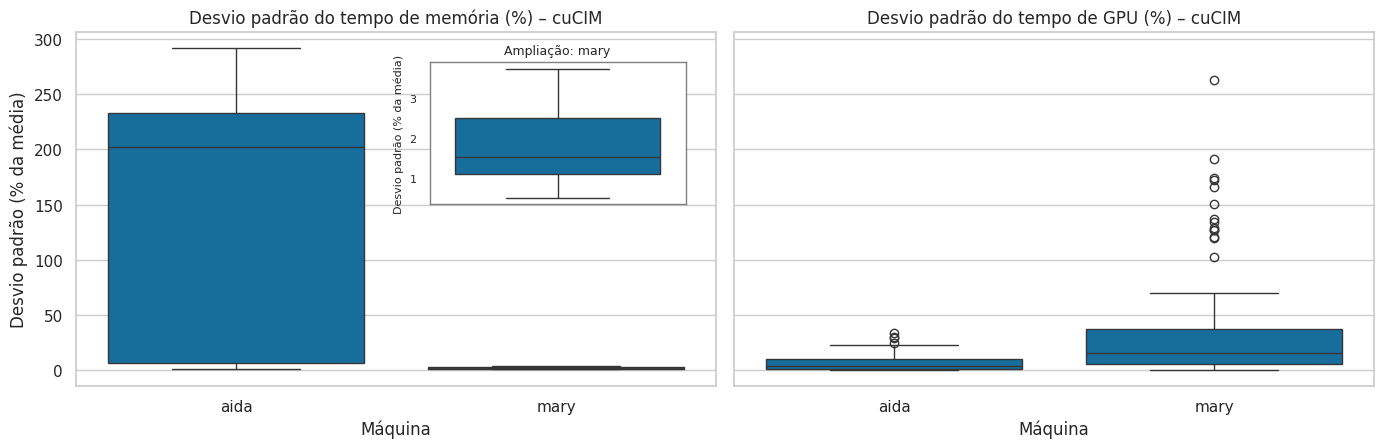

In [212]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Filter to only cuCIM framework
cucim_df = df_summary[df_summary['Framework'] == 'cuCIM'].copy()

# Set up two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Plot 1: Memory Time Std %
sns.boxplot(data=cucim_df, x='Machine', y='Memory Time (s)_std_%', ax=axes[0])
axes[0].set_title('Desvio padrão do tempo de memória (%) – cuCIM')
axes[0].set_xlabel('Máquina')
axes[0].set_ylabel('Desvio padrão (% da média)')

# ➕ Inset zoom for 'mary'
mary_data = cucim_df[cucim_df['Machine'] == 'mary']
axins = inset_axes(axes[0], width="40%", height="40%", loc='upper right', borderpad=2)
sns.boxplot(data=mary_data, x='Machine', y='Memory Time (s)_std_%', ax=axins)

# Clean inset
axins.set_title('Ampliação: mary', fontsize=9)
axins.set_xlabel('')                       # Remove x-axis label
axins.set_xticklabels([])                 # Remove x-tick label ('mary')
axins.set_ylabel('Desvio padrão (% da média)', fontsize=8)  # Add y-axis label
axins.tick_params(labelsize=8)
axins.grid(False)

# Optional: light border for inset
for spine in axins.spines.values():
    spine.set_edgecolor('gray')
    spine.set_linewidth(1)

# Plot 2: GPU Time Std %
sns.boxplot(data=cucim_df, x='Machine', y='Gpu Time (s)_std_%', ax=axes[1])
axes[1].set_title('Desvio padrão do tempo de GPU (%) – cuCIM')
axes[1].set_xlabel('Máquina')

# Define output path
image_filename = f'time_boxplot_general_cuCIM.png'
image_path = os.path.join(output_dir, image_filename)

# Save figure BEFORE showing or closing
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig(image_path, dpi=300, bbox_inches='tight')  # Save first!
print(f"Imagem salva em: {image_path}")

# Then display if needed
plt.show()
plt.close()  # Optional, frees memory


### Plots: Boxplot - Execution Time by operation

In [141]:
df_aida_mary

,Operation,Machine,gpuMemory,Image Size (MiB),Image Dimensions,Total Time (s),Framework,Memory Time (s),Gpu Time (s),Image Size (GiB)
0,Erosion 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",13.214981,Harpia,NaN,NaN,32
1,Dilation 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",66.008873,Harpia,NaN,NaN,32
2,Closing 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",163.611486,Harpia,NaN,NaN,32
3,Opening 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",65.009234,Harpia,NaN,NaN,32
4,Smoothing 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",40.082520,Harpia,NaN,NaN,32
...,...,...,...,...,...,...,...,...,...,...
26979,Erosion 3D binary,mary,NaN,2056.0,"(128, 2052, 2052)",4.285191,cuCIM,4.209031,0.076160,2
26980,Dilation 3D binary,mary,NaN,2056.0,"(128, 2052, 2052)",4.305455,cuCIM,4.229282,0.076173,2
26981,Closing 3D binary,mary,NaN,2056.0,"(128, 2052, 2052)",4.273646,cuCIM,4.191234,0.082411,2
26982,Opening 3D binary,mary,NaN,2056.0,"(128, 2052, 2052)",4.266993,cuCIM,4.183996,0.082997,2


In [210]:
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_execution_time_boxplot(
    df,
    operations,
    image_size_gib,
    framework,
    time_column='Total Time (s)'
):
    """
    Cria um boxplot de tempo de execução por Máquina, com zoom para 'mary'.

    Parâmetros:
    - df: DataFrame original com execuções individuais
    - operations: lista de operações a incluir (ex.: ['resize', 'rotate'])
    - image_size_gib: int, tamanho da imagem em GiB (arredondado de MiB)
    - framework: str, framework a filtrar (ex.: 'cuCIM' ou 'Harpia')
    - time_column: str, coluna de tempo a plotar (padrão: 'Total Time (s)')
    """

    # Cópia e conversão de tamanho
    df_plot = df.copy()
    df_plot['Image Size (GiB)'] = (df_plot['Image Size (MiB)'] / 1024).round().astype(int)

    # Filtrar dados
    df_filt = df_plot[
        (df_plot['Operation'].isin(operations)) &
        (df_plot['Image Size (GiB)'] == image_size_gib) &
        (df_plot['Framework'] == framework)
    ].copy()

    if df_filt.empty:
        print(f"⚠️ Sem dados para: {framework}, {image_size_gib} GiB")
        return

    # Plot principal
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.boxplot(data=df_filt, x='Machine', y=time_column, palette='colorblind', ax=ax)

    ax.set_title(
        f'Tempo de Execução por Máquina\n'
        f'Framework: {framework} • Tamanho: {image_size_gib} GiB\n'
        f'Operações: {", ".join(operations)}'
    )
    ax.set_xlabel('Máquina')
    ax.set_ylabel('Tempo (s)')
    ax.grid(True, axis='y', linestyle='--', alpha=0.4)

    # 🔍 Inset zoom para 'mary'
    mary_df = df_filt[df_filt['Machine'] == 'mary']
    axins = inset_axes(ax, width="40%", height="40%", loc='upper right', borderpad=2)
    sns.boxplot(data=mary_df, x='Machine', y=time_column, palette='colorblind', ax=axins)

    # Limpar inset
    axins.set_title('Ampliação: mary', fontsize=9)
    axins.set_xlabel('')               # sem label no eixo x
    axins.set_xticklabels([])          # sem ticks no eixo x
    axins.set_ylabel('Tempo (s)', fontsize=8)
    axins.tick_params(labelsize=8)
    axins.grid(False)

    # Borda leve no inset
    for spine in axins.spines.values():
        spine.set_edgecolor('gray')
        spine.set_linewidth(1)

    # Define output path
    image_filename = f'time_boxplot_{framework}_{operations[0]}_{image_size_gib}gib.png'
    image_path = os.path.join(output_dir, image_filename)

    # Save figure BEFORE showing or closing
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig(image_path, dpi=300, bbox_inches='tight')  # Save first!
    print(f"Imagem salva em: {image_path}")
    
    # Then display if needed
    plt.show()
    plt.close()  # Optional, frees memory


/tmp/ipykernel_149444/1449325252.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filt, x='Machine', y=time_column, palette='colorblind', ax=ax)
/tmp/ipykernel_149444/1449325252.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=mary_df, x='Machine', y=time_column, palette='colorblind', ax=axins)
/tmp/ipykernel_149444/1449325252.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.93])


Imagem salva em: comp_report_plots/time_boxplot_Harpia_Dilation 3D binary_32gib.png


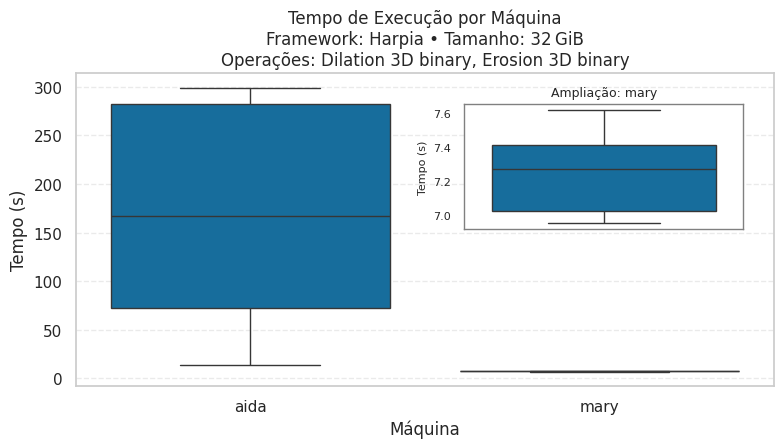

/tmp/ipykernel_149444/1449325252.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filt, x='Machine', y=time_column, palette='colorblind', ax=ax)
/tmp/ipykernel_149444/1449325252.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=mary_df, x='Machine', y=time_column, palette='colorblind', ax=axins)
/tmp/ipykernel_149444/1449325252.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.93])


Imagem salva em: comp_report_plots/time_boxplot_Harpia_Closing 3D binary_32gib.png


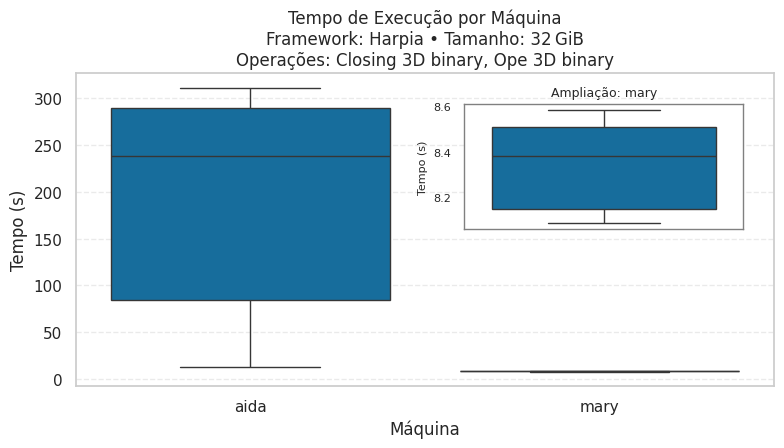

In [211]:
plot_execution_time_boxplot(
    df=df_aida_mary,
    operations=['Dilation 3D binary', 'Erosion 3D binary'],
    image_size_gib=32,
    framework='Harpia'
)

plot_execution_time_boxplot(
    df=df_aida_mary,
    operations=['Closing 3D binary', 'Ope 3D binary'],
    image_size_gib=32,
    framework='Harpia'
)

### Plots: Barplot - Min and Max Time by operation

In [78]:
def filter_entries_with_enough_repeats_and_both_machines(df):
    df = df.copy()
    df['Image Size (GiB)'] = (df['Image Size (MiB)'] / 1024).round().astype(int)

    # Count how many entries exist per combination
    group_counts = (
        df
        .groupby(['Operation', 'Image Size (GiB)', 'Framework', 'Machine'])
        .size()
        .reset_index(name='count')
    )

    # Keep only groups with at least 2 repetitions
    group_counts = group_counts[group_counts['count'] >= 2]

    # Count how many distinct machines have >=2 entries per (op, fw, size)
    machine_coverage = (
        group_counts
        .groupby(['Operation', 'Image Size (GiB)', 'Framework'])['Machine']
        .nunique()
        .reset_index(name='machine_count')
    )

    # Keep only those where both machines (i.e., count == 2) are present
    valid_triples = machine_coverage[machine_coverage['machine_count'] == 2][
        ['Operation', 'Image Size (GiB)', 'Framework']
    ]

    # Merge with the original group_counts to get the valid (op, size, fw, machine) combos
    valid_groups = group_counts.merge(valid_triples, on=['Operation', 'Image Size (GiB)', 'Framework'])

    # Merge with the original df to keep only those entries
    df_filtered = df.merge(
        valid_groups[['Operation', 'Image Size (GiB)', 'Framework', 'Machine']],
        on=['Operation', 'Image Size (GiB)', 'Framework', 'Machine']
    )

    return df_filtered


In [83]:
df_aida_mary_filtered = filter_entries_with_enough_repeats_and_both_machines(df_aida_mary)

In [183]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_min_max_execution_times(
    df,
    operations,
    framework,
    image_size_gib,
    time_column='Total Time (s)'
):
    """
    Plots min and max execution times per operation (shortened), per Machine, as barplots.
    Shows binary status and image size in the title, and number of repetitions per operation in the legend.
    """
    df_plot = df.copy()
    df_plot['Image Size (GiB)'] = (df_plot['Image Size (MiB)'] / 1024).round().astype(int)

    # Filter based on inputs
    df_filtered = df_plot[
        (df_plot['Operation'].isin(operations)) &
        (df_plot['Framework'] == framework) &
        (df_plot['Image Size (GiB)'] == image_size_gib)
    ].copy()

    if df_filtered.empty:
        print(f"⚠️ No data to plot: {framework}, {image_size_gib} GiB")
        return

    # Detect binary or grayscale
    is_binary = any("binary" in op.lower() for op in operations)
    op_type = "Binárias" if is_binary else "Grayscale"

    # Create short operation names (first word)
    short_names = {op: op.split()[0] for op in operations}
    df_filtered['Operation Short'] = df_filtered['Operation'].map(short_names)

    # Count number of repetitions per machine per operation
    num_ops = df_filtered['Operation Short'].nunique()
    counts_per_machine = (
        df_filtered
        .groupby('Machine')
        .size()
        .div(num_ops)
        .astype(int)
        .to_dict()
    )

    # Aggregate min and max
    stats = (
        df_filtered
        .groupby(['Operation Short', 'Machine'])[time_column]
        .agg(['min', 'max'])
        .reset_index()
    )

    # Maintain order of operations
    short_ops = [short_names[op] for op in operations]
    stats['Operation Short'] = pd.Categorical(stats['Operation Short'], categories=short_ops, ordered=True)

    # Create plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    sns.barplot(
        data=stats,
        x='Operation Short',
        y='min',
        hue='Machine',
        ax=axes[0],
        palette='Blues'
    )
    axes[0].set_title(f'Mínimo Tempo Total (s)')
    axes[0].set_xlabel('Operação')
    axes[0].set_ylabel('Tempo (s)')
    axes[0].tick_params(axis='x')

    sns.barplot(
        data=stats,
        x='Operation Short',
        y='max',
        hue='Machine',
        ax=axes[1],
        palette='Reds'
    )
    axes[1].set_title(f'Máximo Tempo Total (s)')
    axes[1].set_xlabel('Operação')
    axes[1].set_ylabel('Tempo (s)')
    axes[1].tick_params(axis='x')

    # Legend with clear "repetitions by operation" label
    machine_labels = {
        machine: f"{machine} (n={count})"
        for machine, count in counts_per_machine.items()
    }

    for ax in axes:
        handles, labels = ax.get_legend_handles_labels()
        new_labels = [machine_labels.get(label, label) for label in labels]
        ax.legend(handles, new_labels, title="Máquina")

    # Title with context
    fig.suptitle(
        f'Operações {op_type}— {framework} — {image_size_gib} GiB —  Tempo Total (s)',
        fontsize=14
    )
    
    # Define output path
    image_filename = f'min_max_execution_time_boxplot_{framework}_{operations[0]}_{image_size_gib}gib.png'
    image_path = os.path.join(output_dir, image_filename)
    
    # Save figure BEFORE showing or closing
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig(image_path, dpi=300, bbox_inches='tight')  # Save first!
    print(f"Imagem salva em: {image_path}")
    
    # Then display if needed
    plt.show()
    plt.close()  # Optional, frees memory


🔧 Plotting: Operações Morfológicas Binárias, Framework: Harpia, Size: 1 GiB
⚠️ No data to plot: Harpia, 1 GiB
🔧 Plotting: Operações Morfológicas Binárias, Framework: Harpia, Size: 2 GiB
⚠️ No data to plot: Harpia, 2 GiB
🔧 Plotting: Operações Morfológicas Binárias, Framework: Harpia, Size: 3 GiB
⚠️ No data to plot: Harpia, 3 GiB
🔧 Plotting: Operações Morfológicas Binárias, Framework: Harpia, Size: 4 GiB
⚠️ No data to plot: Harpia, 4 GiB
🔧 Plotting: Operações Morfológicas Binárias, Framework: Harpia, Size: 8 GiB
⚠️ No data to plot: Harpia, 8 GiB
🔧 Plotting: Operações Morfológicas Binárias, Framework: Harpia, Size: 16 GiB
⚠️ No data to plot: Harpia, 16 GiB
🔧 Plotting: Operações Morfológicas Binárias, Framework: Harpia, Size: 32 GiB
Imagem salva em: comp_report_plots/min_max_execution_time_boxplot_Harpia_Closing 3D binary_32gib.png


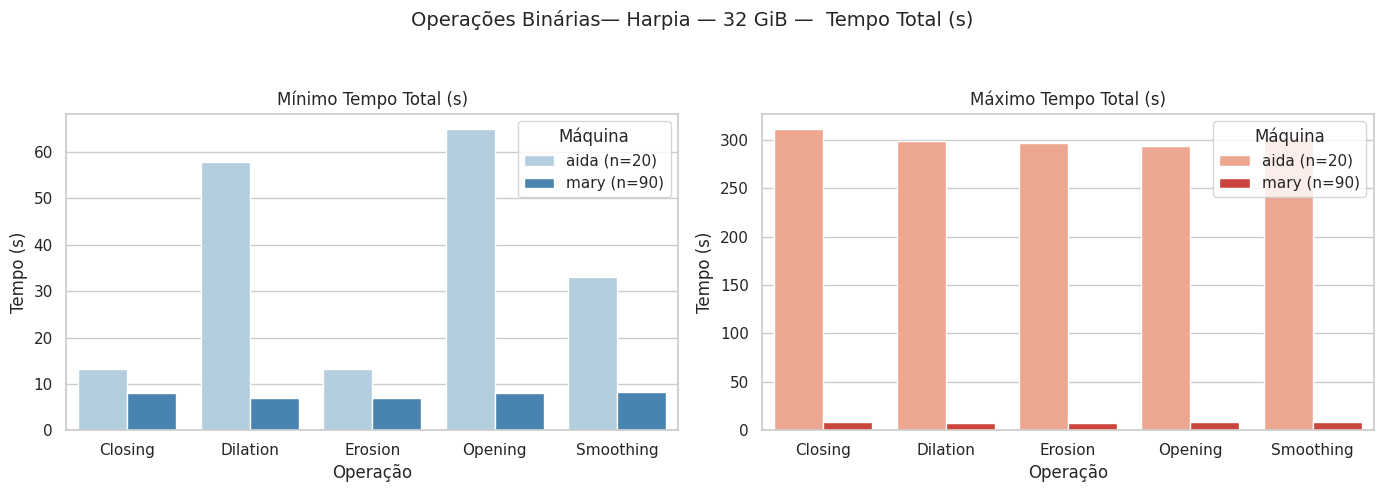

🔧 Plotting: Operações Morfológicas Binárias, Framework: cuCIM, Size: 1 GiB
Imagem salva em: comp_report_plots/min_max_execution_time_boxplot_cuCIM_Closing 3D binary_1gib.png


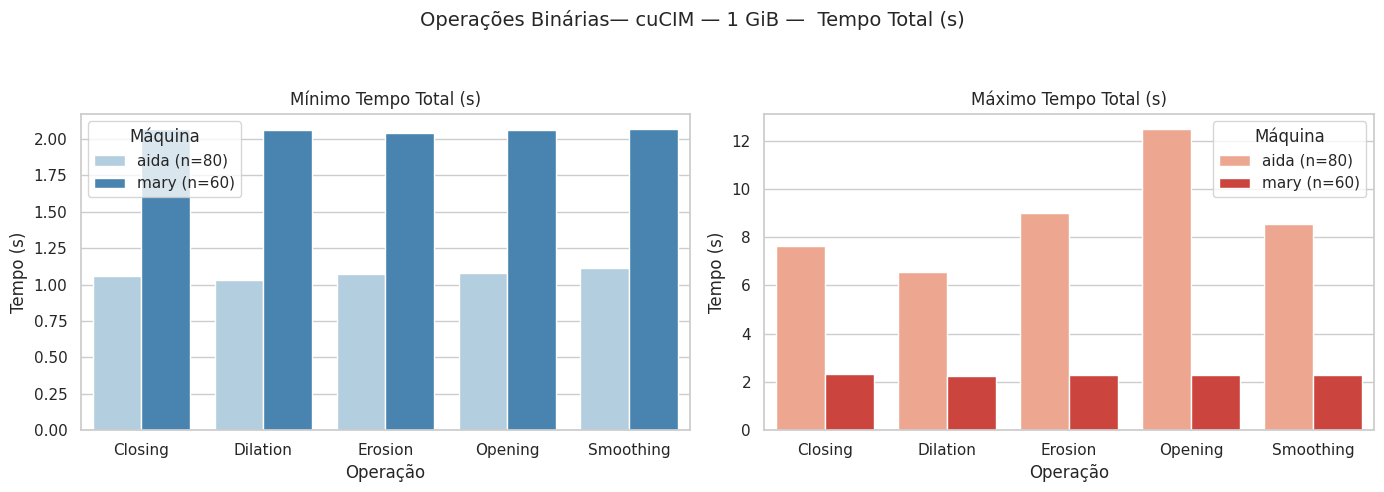

🔧 Plotting: Operações Morfológicas Binárias, Framework: cuCIM, Size: 2 GiB
Imagem salva em: comp_report_plots/min_max_execution_time_boxplot_cuCIM_Closing 3D binary_2gib.png


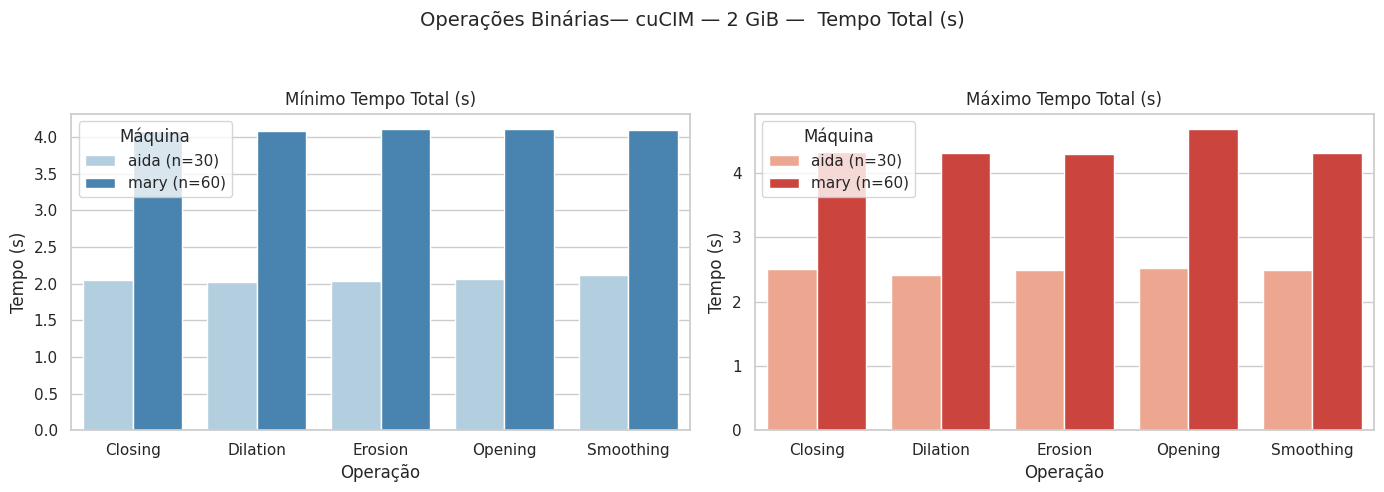

🔧 Plotting: Operações Morfológicas Binárias, Framework: cuCIM, Size: 3 GiB
⚠️ No data to plot: cuCIM, 3 GiB
🔧 Plotting: Operações Morfológicas Binárias, Framework: cuCIM, Size: 4 GiB
Imagem salva em: comp_report_plots/min_max_execution_time_boxplot_cuCIM_Closing 3D binary_4gib.png


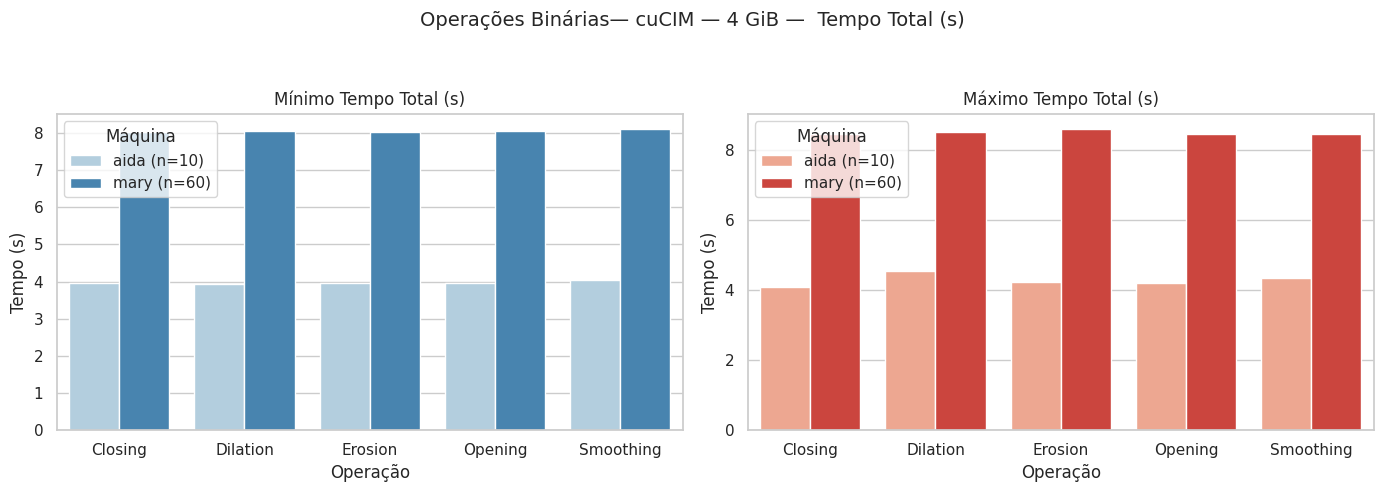

🔧 Plotting: Operações Morfológicas Binárias, Framework: cuCIM, Size: 8 GiB
Imagem salva em: comp_report_plots/min_max_execution_time_boxplot_cuCIM_Closing 3D binary_8gib.png


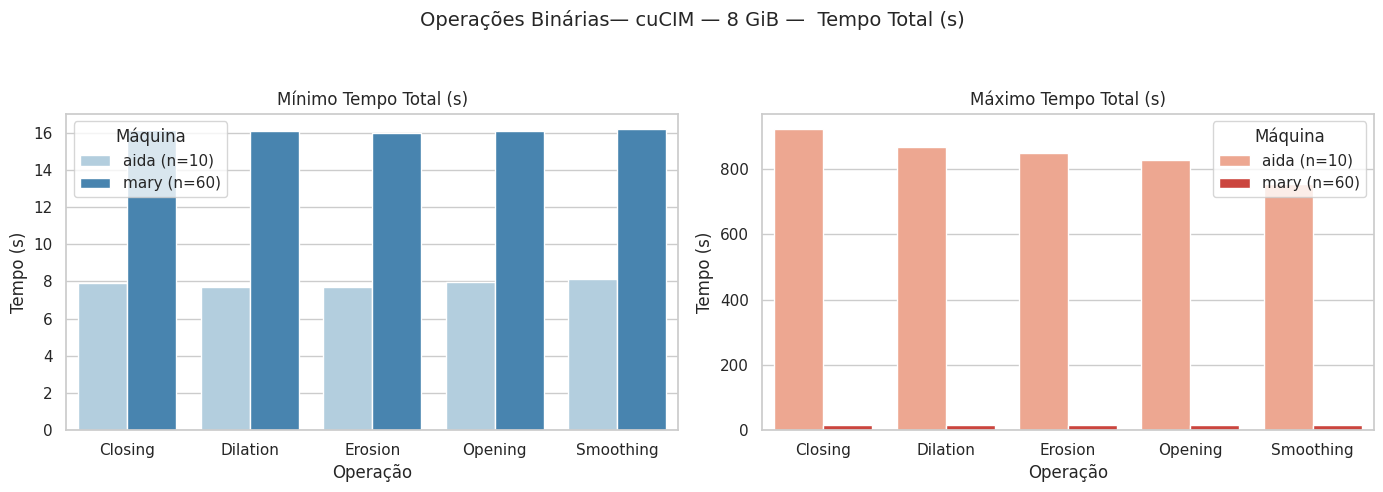

🔧 Plotting: Operações Morfológicas Binárias, Framework: cuCIM, Size: 16 GiB
Imagem salva em: comp_report_plots/min_max_execution_time_boxplot_cuCIM_Closing 3D binary_16gib.png


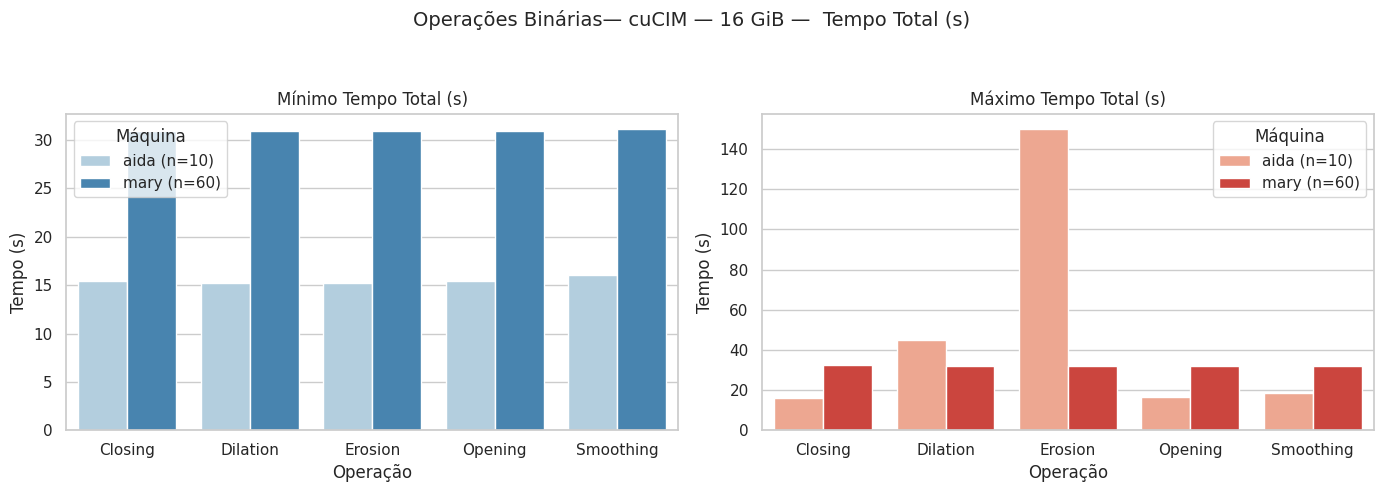

🔧 Plotting: Operações Morfológicas Binárias, Framework: cuCIM, Size: 32 GiB
⚠️ No data to plot: cuCIM, 32 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: Harpia, Size: 1 GiB
⚠️ No data to plot: Harpia, 1 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: Harpia, Size: 2 GiB
⚠️ No data to plot: Harpia, 2 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: Harpia, Size: 3 GiB
⚠️ No data to plot: Harpia, 3 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: Harpia, Size: 4 GiB
⚠️ No data to plot: Harpia, 4 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: Harpia, Size: 8 GiB
⚠️ No data to plot: Harpia, 8 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: Harpia, Size: 16 GiB
⚠️ No data to plot: Harpia, 16 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: Harpia, Size: 32 GiB
⚠️ No data to plot: Harpia, 32 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: cuCIM, Size: 1 GiB
Imagem salva em: comp_report_plot

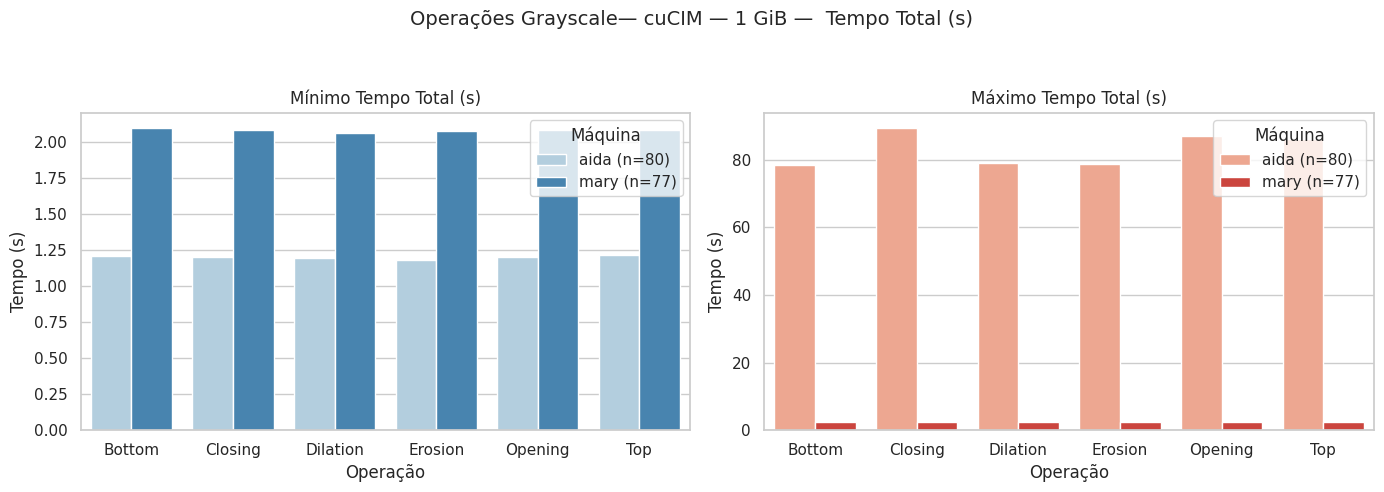

🔧 Plotting: Operações Morfológicas Grayscale, Framework: cuCIM, Size: 2 GiB
Imagem salva em: comp_report_plots/min_max_execution_time_boxplot_cuCIM_Bottom Hat 3D grayscale_2gib.png


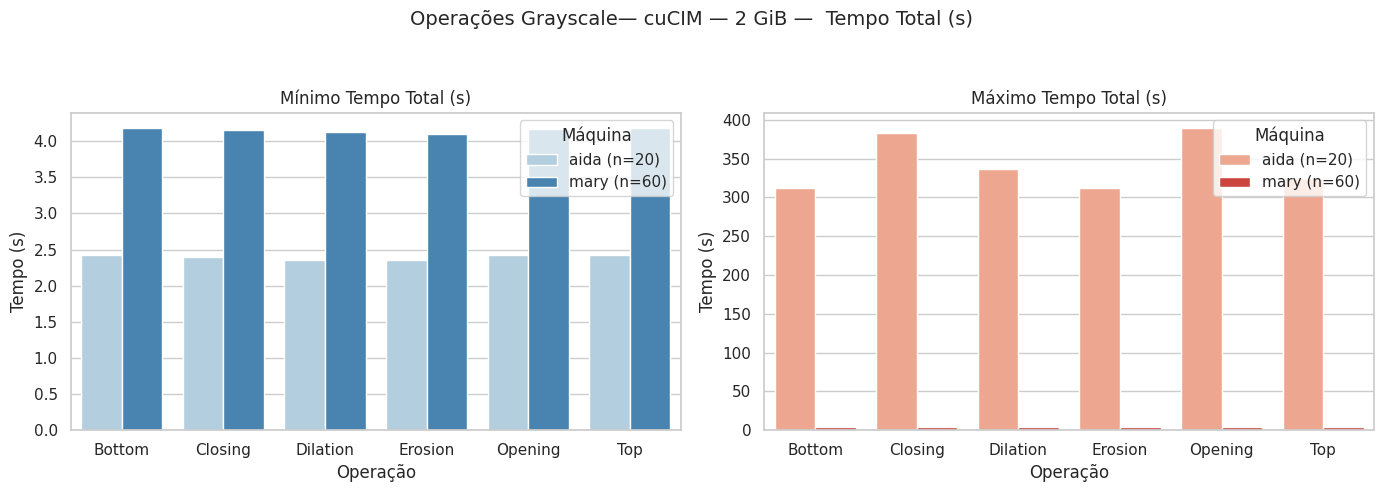

🔧 Plotting: Operações Morfológicas Grayscale, Framework: cuCIM, Size: 3 GiB
⚠️ No data to plot: cuCIM, 3 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: cuCIM, Size: 4 GiB
⚠️ No data to plot: cuCIM, 4 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: cuCIM, Size: 8 GiB
⚠️ No data to plot: cuCIM, 8 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: cuCIM, Size: 16 GiB
⚠️ No data to plot: cuCIM, 16 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: cuCIM, Size: 32 GiB
⚠️ No data to plot: cuCIM, 32 GiB
🔧 Plotting: Filtros, Framework: Harpia, Size: 1 GiB
⚠️ No data to plot: Harpia, 1 GiB
🔧 Plotting: Filtros, Framework: Harpia, Size: 2 GiB
⚠️ No data to plot: Harpia, 2 GiB
🔧 Plotting: Filtros, Framework: Harpia, Size: 3 GiB
⚠️ No data to plot: Harpia, 3 GiB
🔧 Plotting: Filtros, Framework: Harpia, Size: 4 GiB
⚠️ No data to plot: Harpia, 4 GiB
🔧 Plotting: Filtros, Framework: Harpia, Size: 8 GiB
⚠️ No data to plot: Harpia, 8 GiB
🔧 Plotting: Filtros, 

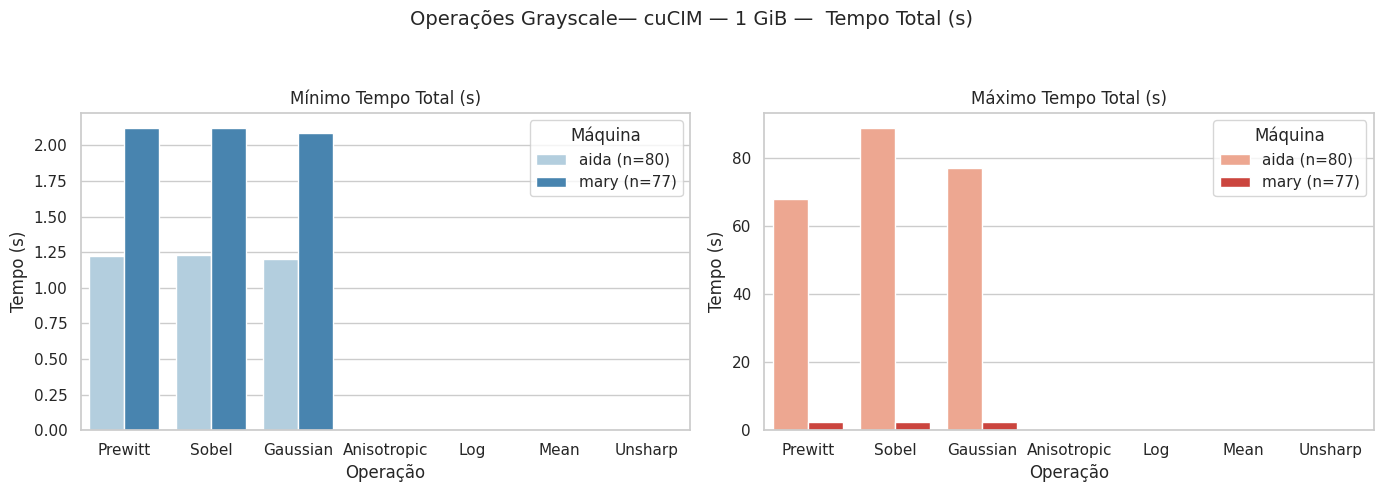

🔧 Plotting: Filtros, Framework: cuCIM, Size: 2 GiB
Imagem salva em: comp_report_plots/min_max_execution_time_boxplot_cuCIM_Prewitt Filter 3D grayscale_2gib.png


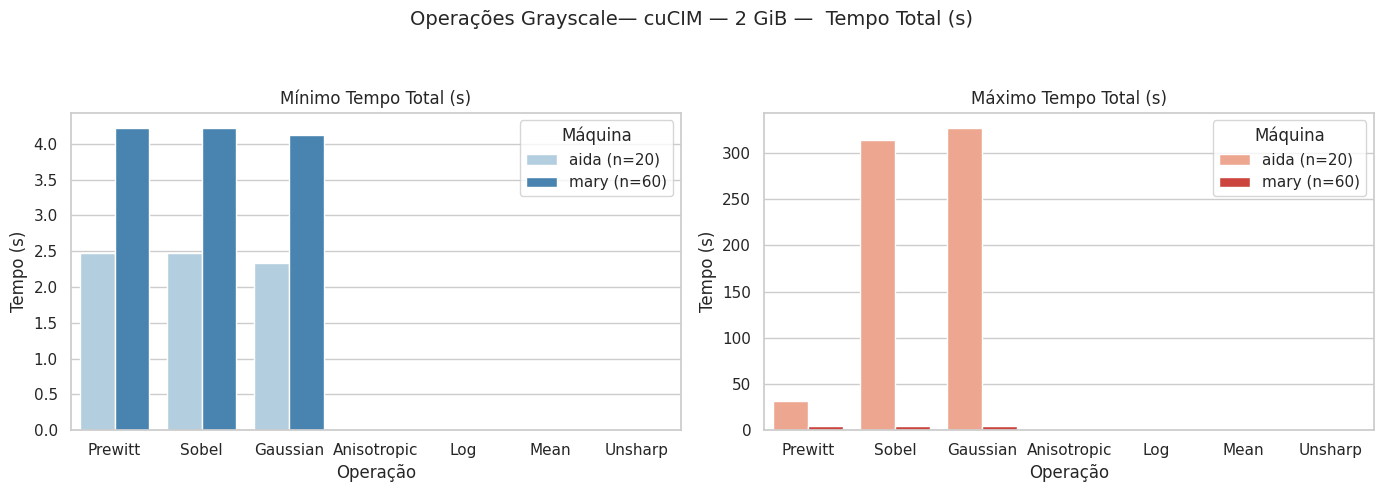

🔧 Plotting: Filtros, Framework: cuCIM, Size: 3 GiB
⚠️ No data to plot: cuCIM, 3 GiB
🔧 Plotting: Filtros, Framework: cuCIM, Size: 4 GiB
⚠️ No data to plot: cuCIM, 4 GiB
🔧 Plotting: Filtros, Framework: cuCIM, Size: 8 GiB
⚠️ No data to plot: cuCIM, 8 GiB
🔧 Plotting: Filtros, Framework: cuCIM, Size: 16 GiB
⚠️ No data to plot: cuCIM, 16 GiB
🔧 Plotting: Filtros, Framework: cuCIM, Size: 32 GiB
⚠️ No data to plot: cuCIM, 32 GiB
🔧 Plotting: Threshold, Framework: Harpia, Size: 1 GiB
⚠️ No data to plot: Harpia, 1 GiB
🔧 Plotting: Threshold, Framework: Harpia, Size: 2 GiB
⚠️ No data to plot: Harpia, 2 GiB
🔧 Plotting: Threshold, Framework: Harpia, Size: 3 GiB
⚠️ No data to plot: Harpia, 3 GiB
🔧 Plotting: Threshold, Framework: Harpia, Size: 4 GiB
⚠️ No data to plot: Harpia, 4 GiB
🔧 Plotting: Threshold, Framework: Harpia, Size: 8 GiB
⚠️ No data to plot: Harpia, 8 GiB
🔧 Plotting: Threshold, Framework: Harpia, Size: 16 GiB
⚠️ No data to plot: Harpia, 16 GiB
🔧 Plotting: Threshold, Framework: Harpia, Size

ValueError: Categorical categories must be unique

In [184]:
image_sizes_gib = [1, 2, 3, 4, 8, 16, 32]
frameworks = ['Harpia', 'cuCIM']

binary_ops = [
    'Closing 3D binary', 'Dilation 3D binary', 'Erosion 3D binary',
    'Opening 3D binary', 'Smoothing 3D binary'
]

grayscale_ops = [
    'Bottom Hat 3D grayscale', 'Closing 3D grayscale', 'Dilation 3D grayscale',
    'Erosion 3D grayscale', 'Opening 3D grayscale', 'Top Hat 3D grayscale'
]

filter_ops = [
    'Prewitt Filter 3D grayscale', 'Sobel Filter 3D grayscale', 'Gaussian Filter 3D grayscale',
    'Anisotropic Diffusion Filter 3D grayscale', 'Log Filter 3D grayscale',
    'Mean Filter 3D grayscale', 'Unsharp Mask Filter 3D grayscale'
]

threshold_ops = [
    'Threshold Niblack', 'Threshold Sauvola', 'Threshold Mean'
]

operation_groups = [
    ("Operações Morfológicas Binárias", binary_ops),
    ("Operações Morfológicas Grayscale", grayscale_ops),
    ("Filtros", filter_ops),
    ("Threshold", threshold_ops)
]

for group_name, operations in operation_groups:
    for framework in frameworks:
        for size in image_sizes_gib:
            print(f'🔧 Plotting: {group_name}, Framework: {framework}, Size: {size} GiB')
            plot_min_max_execution_times(
                df=df_aida_mary_filtered,
                operations=operations,
                framework=framework,
                image_size_gib=size,
                time_column='Total Time (s)'
            )

In [205]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

def plot_min_max_execution_times(
    df,
    summarize_df,
    operations,
    framework,
    image_size_gib,
    output_dir,
    time_column='Total Time (s)'
):
    """
    Plots:
    - Minimum execution time (barplot)
    - Maximum execution time (barplot)
    - Standard deviation (%) of execution time (barplot)

    Parameters:
    - df: raw DataFrame with execution times
    - summarize_df: summarized DataFrame (with mean/std/%std columns)
    - operations: list of operations to include
    - framework: framework name (e.g., 'cuCIM')
    - image_size_gib: int, size of image to filter by
    - output_dir: directory to save the resulting figure
    - time_column: execution time metric to analyze
    """
    df_plot = df.copy()
    df_plot['Image Size (GiB)'] = (df_plot['Image Size (MiB)'] / 1024).round().astype(int)

    df_filtered = df_plot[
        (df_plot['Operation'].isin(operations)) &
        (df_plot['Framework'] == framework) &
        (df_plot['Image Size (GiB)'] == image_size_gib)
    ].copy()

    if df_filtered.empty:
        print(f"⚠️ Sem dados para: {framework}, {image_size_gib} GiB")
        return

    is_binary = any("binary" in op.lower() for op in operations)
    op_type = "Binárias" if is_binary else "Grayscale"

    # Map short operation names
    short_names = {op: op.split()[0] for op in operations}
    df_filtered['Operation Short'] = df_filtered['Operation'].map(short_names)

    # Count repetitions per machine
    num_ops = df_filtered['Operation Short'].nunique()
    counts_per_machine = (
        df_filtered
        .groupby('Machine')
        .size()
        .div(num_ops)
        .astype(int)
        .to_dict()
    )

    # Aggregate min and max times
    stats = (
        df_filtered
        .groupby(['Operation Short', 'Machine'])[time_column]
        .agg(['min', 'max'])
        .reset_index()
    )

    # Order operation labels
    short_ops = [short_names[op] for op in operations]
    stats['Operation Short'] = pd.Categorical(stats['Operation Short'], categories=short_ops, ordered=True)

    # Prepare std data from summarized df
    summarize_df = summarize_df.copy()
    summarize_df['Image Size (GiB)'] = summarize_df['Image Size (GiB)'] if 'Image Size (GiB)' in summarize_df.columns else (summarize_df['Image Size (MiB)'] / 1024).round().astype(int)
    summarize_df = summarize_df[
        (summarize_df['Framework'] == framework) &
        (summarize_df['Image Size (GiB)'] == image_size_gib) &
        (summarize_df['Operation'].isin(operations))
    ].copy()

    if summarize_df.empty:
        print("⚠️ Nenhum dado de desvio padrão encontrado para o terceiro gráfico.")
        return

    summarize_df['Operation Short'] = summarize_df['Operation'].map(short_names)
    summarize_df['Operation Short'] = pd.Categorical(summarize_df['Operation Short'], categories=short_ops, ordered=True)

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(21, 5), gridspec_kw={'width_ratios': [1.3, 1.3, 1]})

    sns.barplot(
        data=stats,
        x='Operation Short',
        y='min',
        hue='Machine',
        ax=axes[0],
        palette='Blues'
    )
    axes[0].set_title('Mínimo Tempo Total (s)')
    axes[0].set_xlabel('Operação')
    axes[0].set_ylabel('Tempo (s)')

    sns.barplot(
        data=stats,
        x='Operation Short',
        y='max',
        hue='Machine',
        ax=axes[1],
        palette='Reds'
    )
    axes[1].set_title('Máximo Tempo Total (s)')
    axes[1].set_xlabel('Operação')
    axes[1].set_ylabel('Tempo (s)')

    sns.barplot(
        data=summarize_df,
        x='Operation Short',
        y='Total Time (s)_std_%',
        hue='Machine',
        ax=axes[2],
        palette='colorblind'
    )
    axes[2].set_title('Desvio Padrão (%) do Tempo Total')
    axes[2].set_xlabel('Operação')
    axes[2].set_ylabel('Desvio (%)')

    # Update legends
    machine_labels = {
        machine: f"{machine} (n={count})"
        for machine, count in counts_per_machine.items()
    }

    for ax in axes[:2]:
        handles, labels = ax.get_legend_handles_labels()
        new_labels = [machine_labels.get(label, label) for label in labels]
        ax.legend(handles, new_labels, title="Máquina")

    axes[2].legend(title="Máquina")

    # Title and save
    fig.suptitle(
        f'Operações {op_type} — {framework} — {image_size_gib} GiB — Tempo Total (s)',
        fontsize=14
    )

    image_filename = f'min_max_std_barplot_{framework}_{operations[0]}_{image_size_gib}gib.png'
    image_path = os.path.join(output_dir, image_filename)

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig(image_path, dpi=300, bbox_inches='tight')
    print(f"📊 Imagem salva em: {image_path}")

    plt.show()
    plt.close()


🔧 Plotting: Operações Morfológicas Binárias, Framework: Harpia, Size: 1 GiB
⚠️ Sem dados para: Harpia, 1 GiB
🔧 Plotting: Operações Morfológicas Binárias, Framework: Harpia, Size: 2 GiB
⚠️ Sem dados para: Harpia, 2 GiB
🔧 Plotting: Operações Morfológicas Binárias, Framework: Harpia, Size: 3 GiB
⚠️ Sem dados para: Harpia, 3 GiB
🔧 Plotting: Operações Morfológicas Binárias, Framework: Harpia, Size: 4 GiB
⚠️ Sem dados para: Harpia, 4 GiB
🔧 Plotting: Operações Morfológicas Binárias, Framework: Harpia, Size: 8 GiB
⚠️ Sem dados para: Harpia, 8 GiB
🔧 Plotting: Operações Morfológicas Binárias, Framework: Harpia, Size: 16 GiB
⚠️ Sem dados para: Harpia, 16 GiB
🔧 Plotting: Operações Morfológicas Binárias, Framework: Harpia, Size: 32 GiB
📊 Imagem salva em: comp_report_plots/min_max_std_barplot_Harpia_Closing 3D binary_32gib.png


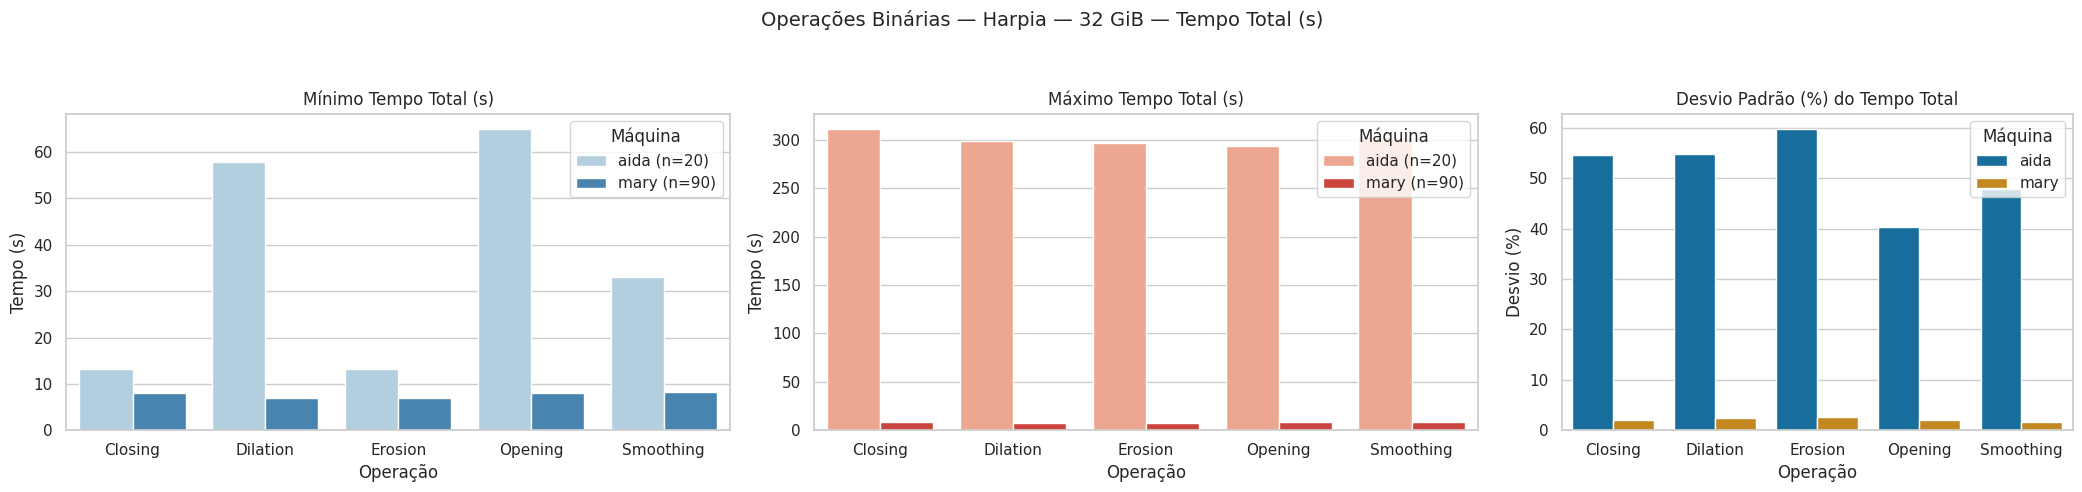

🔧 Plotting: Operações Morfológicas Binárias, Framework: cuCIM, Size: 1 GiB
📊 Imagem salva em: comp_report_plots/min_max_std_barplot_cuCIM_Closing 3D binary_1gib.png


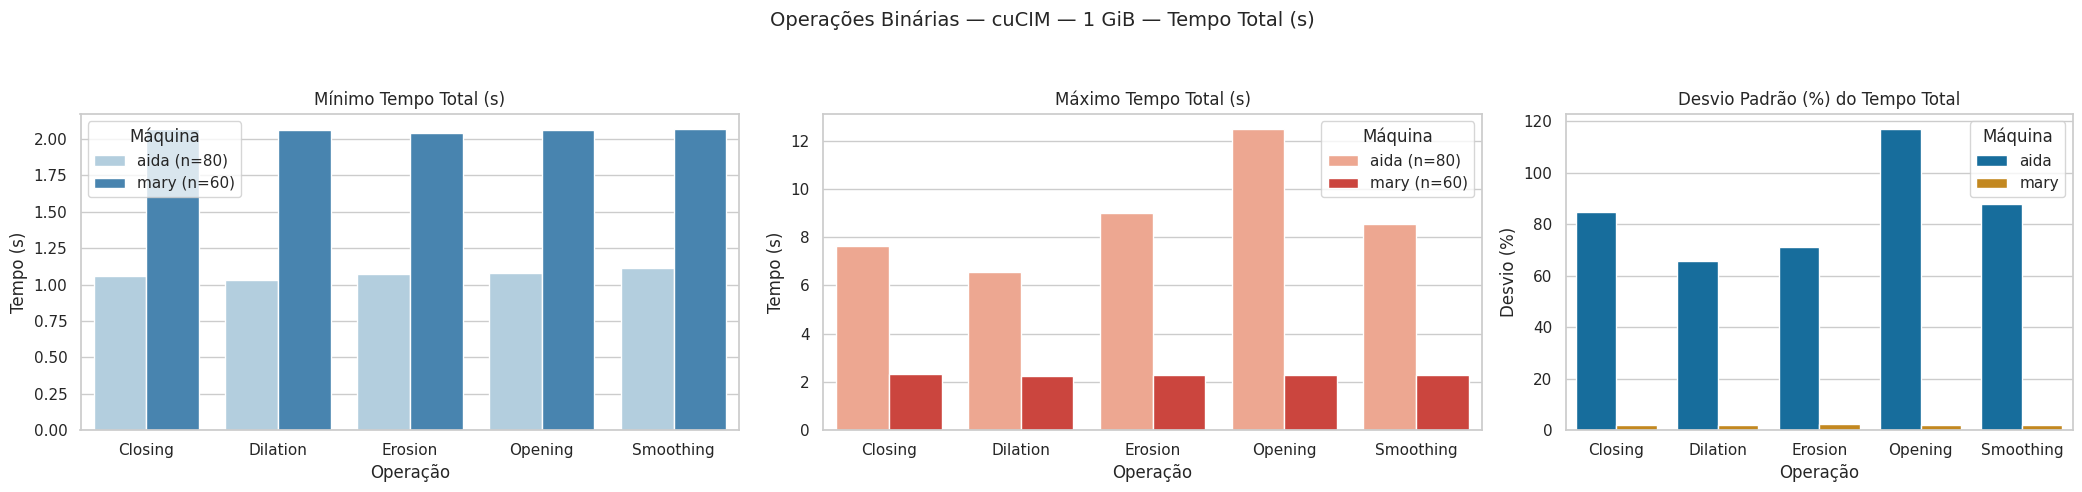

🔧 Plotting: Operações Morfológicas Binárias, Framework: cuCIM, Size: 2 GiB
📊 Imagem salva em: comp_report_plots/min_max_std_barplot_cuCIM_Closing 3D binary_2gib.png


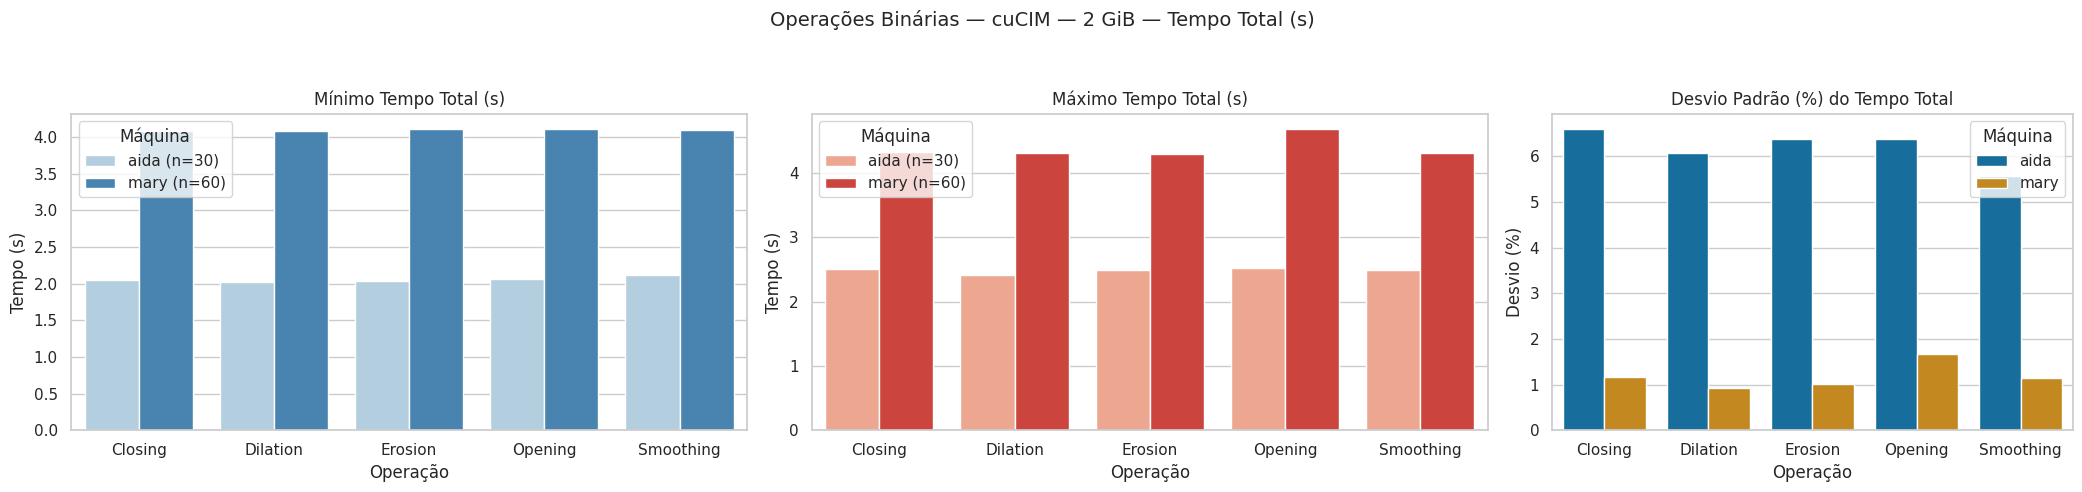

🔧 Plotting: Operações Morfológicas Binárias, Framework: cuCIM, Size: 3 GiB
⚠️ Sem dados para: cuCIM, 3 GiB
🔧 Plotting: Operações Morfológicas Binárias, Framework: cuCIM, Size: 4 GiB
📊 Imagem salva em: comp_report_plots/min_max_std_barplot_cuCIM_Closing 3D binary_4gib.png


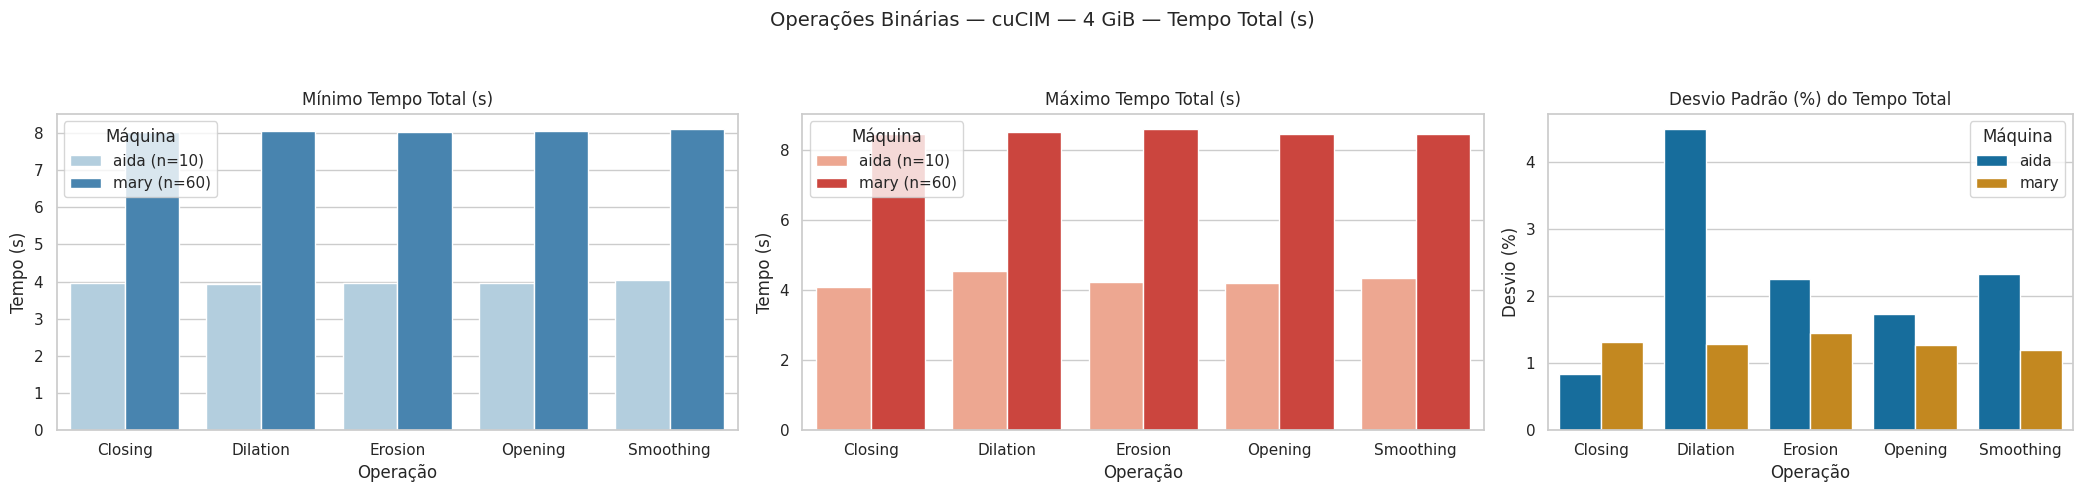

🔧 Plotting: Operações Morfológicas Binárias, Framework: cuCIM, Size: 8 GiB
📊 Imagem salva em: comp_report_plots/min_max_std_barplot_cuCIM_Closing 3D binary_8gib.png


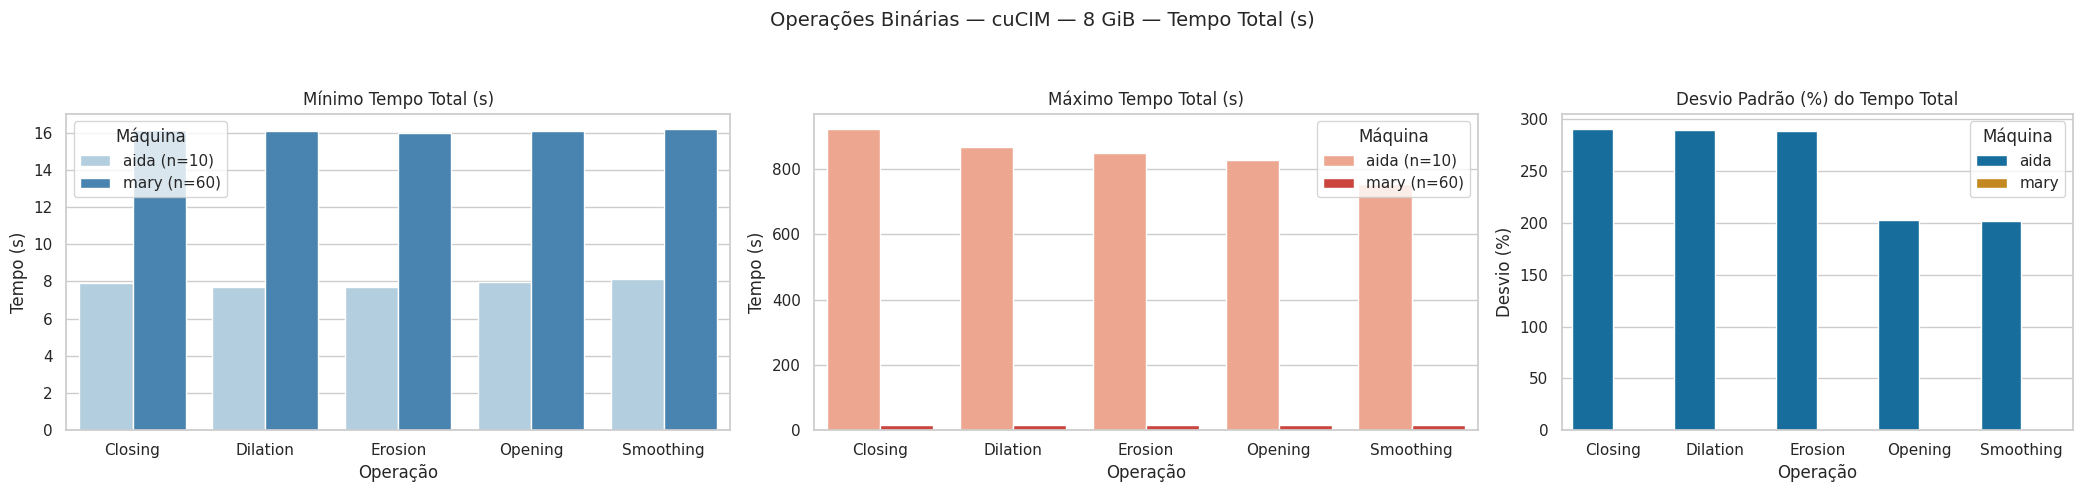

🔧 Plotting: Operações Morfológicas Binárias, Framework: cuCIM, Size: 16 GiB
📊 Imagem salva em: comp_report_plots/min_max_std_barplot_cuCIM_Closing 3D binary_16gib.png


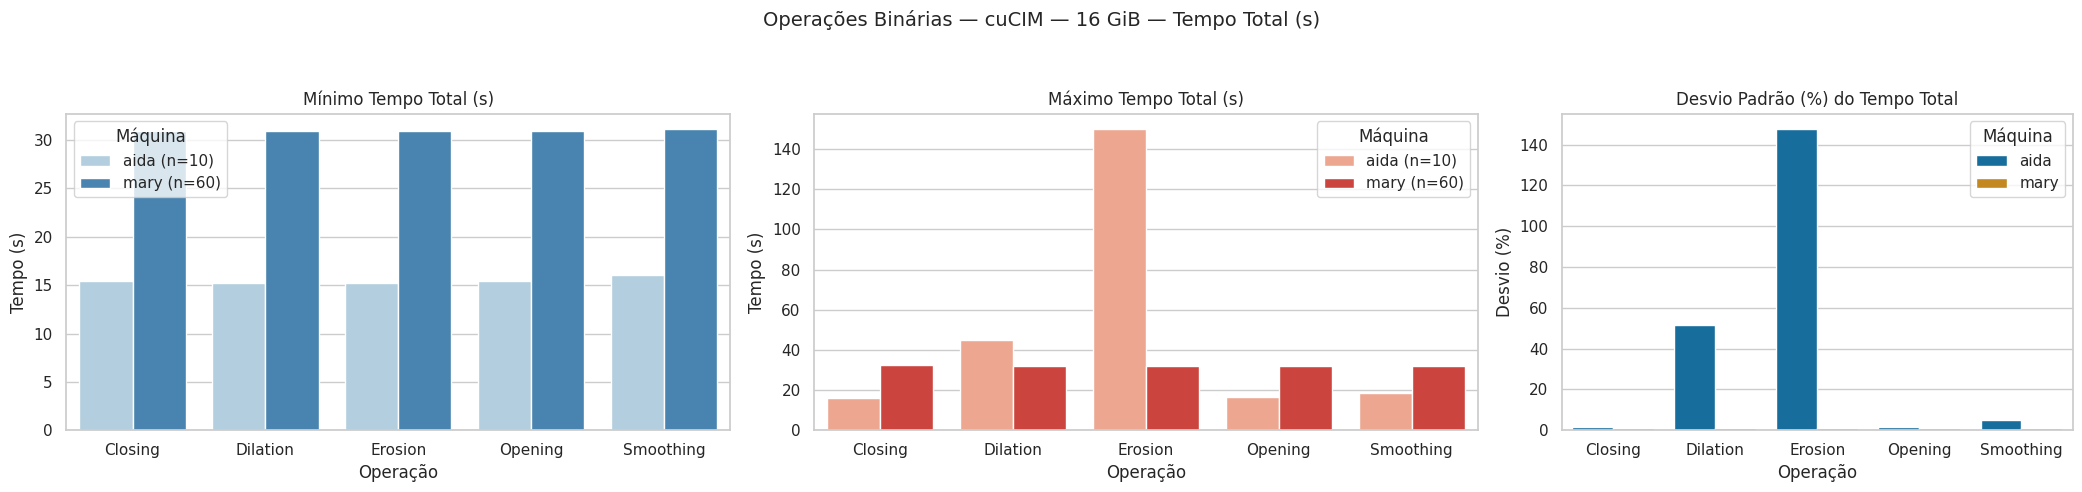

🔧 Plotting: Operações Morfológicas Binárias, Framework: cuCIM, Size: 32 GiB
⚠️ Sem dados para: cuCIM, 32 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: Harpia, Size: 1 GiB
⚠️ Sem dados para: Harpia, 1 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: Harpia, Size: 2 GiB
⚠️ Sem dados para: Harpia, 2 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: Harpia, Size: 3 GiB
⚠️ Sem dados para: Harpia, 3 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: Harpia, Size: 4 GiB
⚠️ Sem dados para: Harpia, 4 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: Harpia, Size: 8 GiB
⚠️ Sem dados para: Harpia, 8 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: Harpia, Size: 16 GiB
⚠️ Sem dados para: Harpia, 16 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: Harpia, Size: 32 GiB
⚠️ Sem dados para: Harpia, 32 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: cuCIM, Size: 1 GiB
📊 Imagem salva em: comp_report_plots/min_

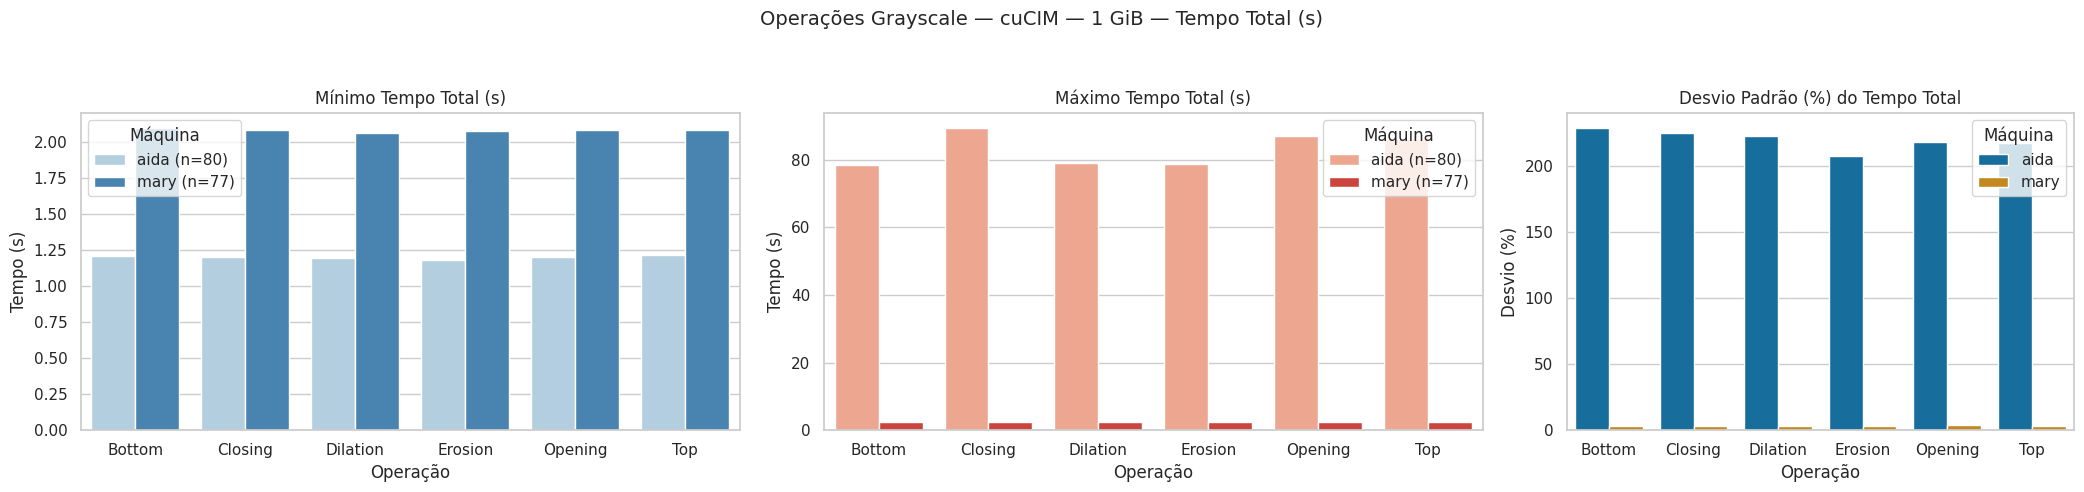

🔧 Plotting: Operações Morfológicas Grayscale, Framework: cuCIM, Size: 2 GiB
📊 Imagem salva em: comp_report_plots/min_max_std_barplot_cuCIM_Bottom Hat 3D grayscale_2gib.png


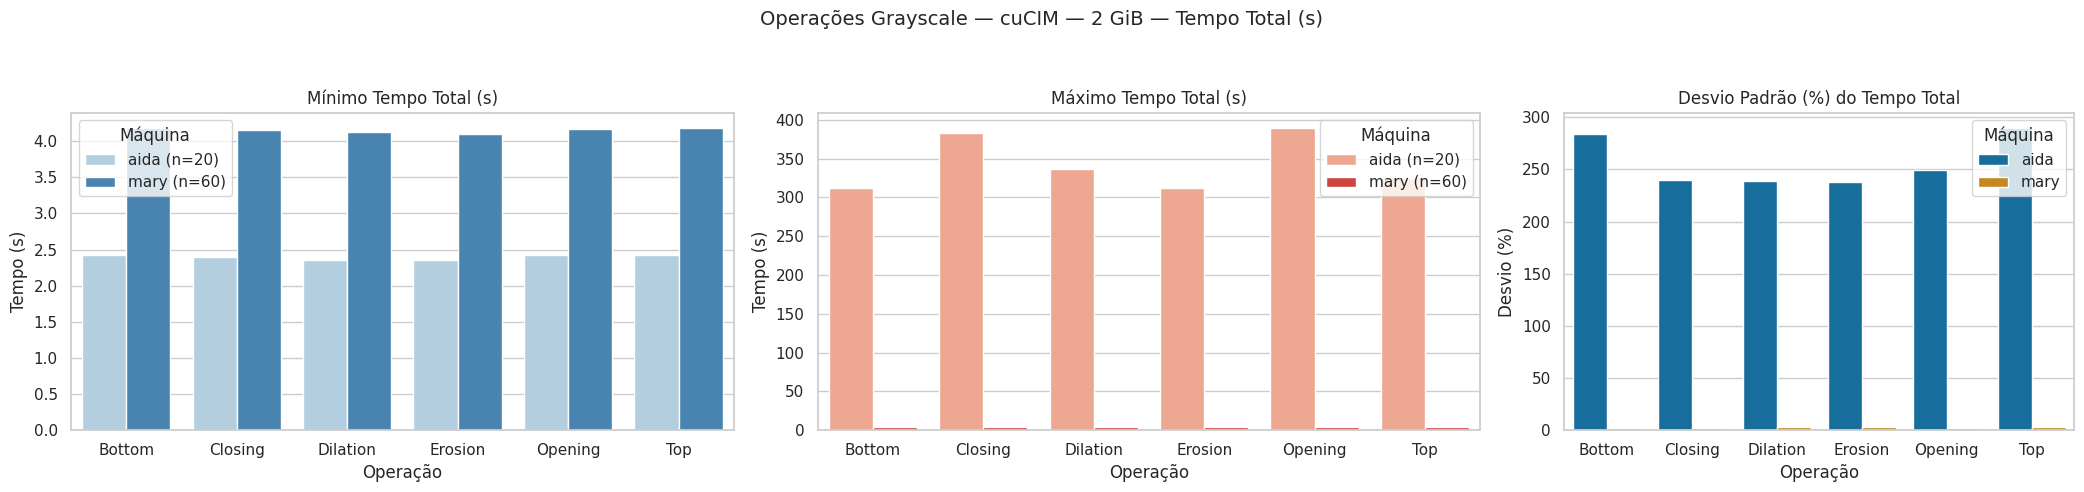

🔧 Plotting: Operações Morfológicas Grayscale, Framework: cuCIM, Size: 3 GiB
⚠️ Sem dados para: cuCIM, 3 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: cuCIM, Size: 4 GiB
⚠️ Sem dados para: cuCIM, 4 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: cuCIM, Size: 8 GiB
⚠️ Sem dados para: cuCIM, 8 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: cuCIM, Size: 16 GiB
⚠️ Sem dados para: cuCIM, 16 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: cuCIM, Size: 32 GiB
⚠️ Sem dados para: cuCIM, 32 GiB
🔧 Plotting: Filtros, Framework: Harpia, Size: 1 GiB
⚠️ Sem dados para: Harpia, 1 GiB
🔧 Plotting: Filtros, Framework: Harpia, Size: 2 GiB
⚠️ Sem dados para: Harpia, 2 GiB
🔧 Plotting: Filtros, Framework: Harpia, Size: 3 GiB
⚠️ Sem dados para: Harpia, 3 GiB
🔧 Plotting: Filtros, Framework: Harpia, Size: 4 GiB
⚠️ Sem dados para: Harpia, 4 GiB
🔧 Plotting: Filtros, Framework: Harpia, Size: 8 GiB
⚠️ Sem dados para: Harpia, 8 GiB
🔧 Plotting: Filtros, Framework:

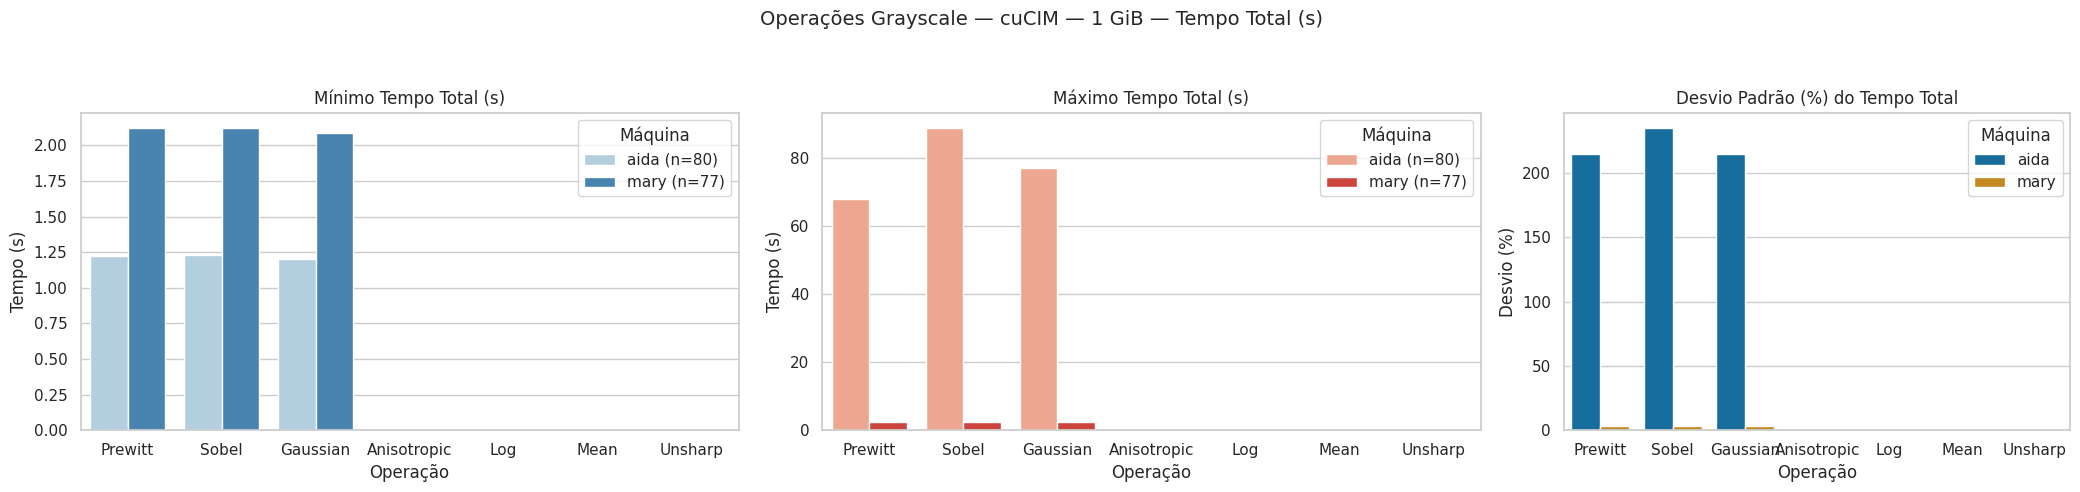

🔧 Plotting: Filtros, Framework: cuCIM, Size: 2 GiB
📊 Imagem salva em: comp_report_plots/min_max_std_barplot_cuCIM_Prewitt Filter 3D grayscale_2gib.png


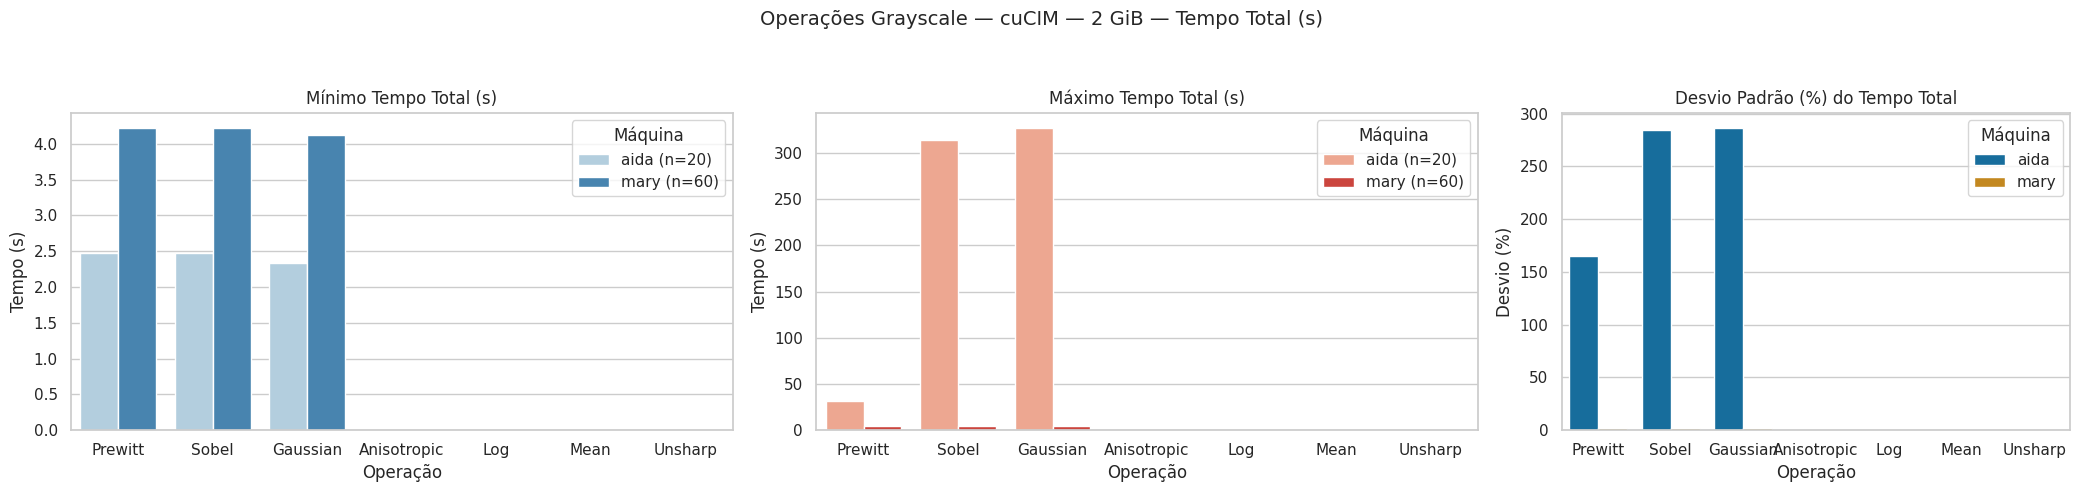

🔧 Plotting: Filtros, Framework: cuCIM, Size: 3 GiB
⚠️ Sem dados para: cuCIM, 3 GiB
🔧 Plotting: Filtros, Framework: cuCIM, Size: 4 GiB
⚠️ Sem dados para: cuCIM, 4 GiB
🔧 Plotting: Filtros, Framework: cuCIM, Size: 8 GiB
⚠️ Sem dados para: cuCIM, 8 GiB
🔧 Plotting: Filtros, Framework: cuCIM, Size: 16 GiB
⚠️ Sem dados para: cuCIM, 16 GiB
🔧 Plotting: Filtros, Framework: cuCIM, Size: 32 GiB
⚠️ Sem dados para: cuCIM, 32 GiB
🔧 Plotting: Threshold, Framework: Harpia, Size: 1 GiB
⚠️ Sem dados para: Harpia, 1 GiB
🔧 Plotting: Threshold, Framework: Harpia, Size: 2 GiB
⚠️ Sem dados para: Harpia, 2 GiB
🔧 Plotting: Threshold, Framework: Harpia, Size: 3 GiB
⚠️ Sem dados para: Harpia, 3 GiB
🔧 Plotting: Threshold, Framework: Harpia, Size: 4 GiB
⚠️ Sem dados para: Harpia, 4 GiB
🔧 Plotting: Threshold, Framework: Harpia, Size: 8 GiB
⚠️ Sem dados para: Harpia, 8 GiB
🔧 Plotting: Threshold, Framework: Harpia, Size: 16 GiB
⚠️ Sem dados para: Harpia, 16 GiB
🔧 Plotting: Threshold, Framework: Harpia, Size: 32 GiB
⚠️

ValueError: Categorical categories must be unique

In [209]:
image_sizes_gib = [1, 2, 3, 4, 8, 16, 32]
frameworks = ['Harpia', 'cuCIM']

binary_ops = [
    'Closing 3D binary', 'Dilation 3D binary', 'Erosion 3D binary',
    'Opening 3D binary', 'Smoothing 3D binary'
]

grayscale_ops = [
    'Bottom Hat 3D grayscale', 'Closing 3D grayscale', 'Dilation 3D grayscale',
    'Erosion 3D grayscale', 'Opening 3D grayscale', 'Top Hat 3D grayscale'
]

filter_ops = [
    'Prewitt Filter 3D grayscale', 'Sobel Filter 3D grayscale', 'Gaussian Filter 3D grayscale',
    'Anisotropic Diffusion Filter 3D grayscale', 'Log Filter 3D grayscale',
    'Mean Filter 3D grayscale', 'Unsharp Mask Filter 3D grayscale'
]

threshold_ops = [
    'Threshold Niblack', 'Threshold Sauvola', 'Threshold Mean'
]

operation_groups = [
    ("Operações Morfológicas Binárias", binary_ops),
    ("Operações Morfológicas Grayscale", grayscale_ops),
    ("Filtros", filter_ops),
    ("Threshold", threshold_ops)
]

for group_name, operations in operation_groups:
    for framework in frameworks:
        for size in image_sizes_gib:
            print(f'🔧 Plotting: {group_name}, Framework: {framework}, Size: {size} GiB')
            plot_min_max_execution_times(
                df=df_aida_mary_filtered,
                summarize_df=df_summary,
                operations=operations,
                framework=framework,
                image_size_gib=size,
                output_dir=output_dir,
                time_column='Total Time (s)'
            )

In [200]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_min_max_execution_times(
    df,
    summarize_df,
    operations,
    framework,
    image_size_gib,
    output_dir,
    time_column='Total Time (s)'
):
    # Copia e preenche colunas
    df_plot = df.copy()
    df_plot['Image Size (GiB)'] = (df_plot['Image Size (MiB)'] / 1024).round().astype(int)

    df_filtered = df_plot[
        (df_plot['Operation'].isin(operations)) &
        (df_plot['Framework'] == framework) &
        (df_plot['Image Size (GiB)'] == image_size_gib)
    ].copy()

    if df_filtered.empty:
        print(f"⚠️ Sem dados para: {framework}, {image_size_gib} GiB")
        return

    is_binary = any("binary" in op.lower() for op in operations)
    op_type = "Binárias" if is_binary else "Escala de Cinza"

    short_names = {op: op.split()[0] for op in operations}
    df_filtered['Operation Short'] = df_filtered['Operation'].map(short_names)

    num_ops = df_filtered['Operation Short'].nunique()
    counts_per_machine = (
        df_filtered
        .groupby('Machine')
        .size()
        .div(num_ops)
        .astype(int)
        .to_dict()
    )

    stats = (
        df_filtered
        .groupby(['Operation Short', 'Machine'])[time_column]
        .agg(['min', 'max'])
        .reset_index()
    )
    short_ops = [short_names[op] for op in operations]
    stats['Operation Short'] = pd.Categorical(stats['Operation Short'], categories=short_ops, ordered=True)

    # Map std % from summarize_df
    summarize_filtered = summarize_df[
    (summarize_df['Framework'] == framework) &
    (summarize_df['Image Size (GiB)'] == image_size_gib) &
    (summarize_df['Operation'].isin(operations))].copy()
    summarize_filtered['Operation Short'] = summarize_filtered['Operation'].map(short_names)
    std_map = summarize_filtered.set_index(['Operation Short', 'Machine'])[f'{time_column}_std_%'].to_dict()

    # 🎨 Plotting
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    sns.barplot(data=stats, x='Operation Short', y='min', hue='Machine', ax=axes[0], palette='Blues')
    axes[0].set_title(f'Mínimo Tempo Total (s)')
    axes[0].set_xlabel('Operação')
    axes[0].set_ylabel('Tempo (s)')

    ax_max = axes[1]
    sns.barplot(data=stats, x='Operation Short', y='max', hue='Machine', ax=ax_max, palette='Reds')
    ax_max.set_title(f'Máximo Tempo Total (s)')
    ax_max.set_xlabel('Operação')
    ax_max.set_ylabel('Tempo (s)')

    # ✅ Annotate std% on bars
    for bar in ax_max.patches:
        height = bar.get_height()
        x = bar.get_x() + bar.get_width() / 2
        op_short = bar.get_x() + bar.get_width() / 2
        op = bar.get_x()
        operation = bar.get_label()  # this returns 'Machine'
        machine = bar.get_facecolor()  # not helpful

    # Better: use the data in `stats` directly
    for i, row in stats.iterrows():
        op = row['Operation Short']
        machine = row['Machine']
        max_val = row['max']
        std_val = std_map.get((op, machine), None)

        if std_val is not None:
            # Locate the matching bar
            x_pos = short_ops.index(op)
            hue_offset = 0.2 if machine == 'mary' else -0.2  # manual adjustment depending on seaborn order
            axes[1].annotate(
                f'{std_val:.1f}%',
                (x_pos + hue_offset, max_val),
                ha='center',
                va='bottom',
                fontsize=9,
                xytext=(0, 3),
                textcoords='offset points'
            )

    # 👥 Legends
    machine_labels = {
        machine: f"{machine} (n={count})"
        for machine, count in counts_per_machine.items()
    }
    for ax in axes:
        handles, labels = ax.get_legend_handles_labels()
        new_labels = [machine_labels.get(label, label) for label in labels]
        ax.legend(handles, new_labels, title="Máquina")

    # 📌 Title
    fig.suptitle(
        f'Operações {op_type} — {framework} — {image_size_gib} GiB — Tempo Total (s)',
        fontsize=14
    )

    # Save
    plt.tight_layout(rect=[0, 0, 1, 0.9])
    image_filename = f'min_max_execution_time_boxplot_{framework}_{operations[0]}_{image_size_gib}gib.png'
    image_path = os.path.join(output_dir, image_filename)
    plt.savefig(image_path, dpi=300, bbox_inches='tight')
    print(f"Imagem salva em: {image_path}")
    plt.show()
    plt.close()


🔧 Plotting: Operações Morfológicas Binárias, Framework: Harpia, Size: 1 GiB
⚠️ Sem dados para: Harpia, 1 GiB
🔧 Plotting: Operações Morfológicas Binárias, Framework: Harpia, Size: 2 GiB
⚠️ Sem dados para: Harpia, 2 GiB
🔧 Plotting: Operações Morfológicas Binárias, Framework: Harpia, Size: 3 GiB
⚠️ Sem dados para: Harpia, 3 GiB
🔧 Plotting: Operações Morfológicas Binárias, Framework: Harpia, Size: 4 GiB
⚠️ Sem dados para: Harpia, 4 GiB
🔧 Plotting: Operações Morfológicas Binárias, Framework: Harpia, Size: 8 GiB
⚠️ Sem dados para: Harpia, 8 GiB
🔧 Plotting: Operações Morfológicas Binárias, Framework: Harpia, Size: 16 GiB
⚠️ Sem dados para: Harpia, 16 GiB
🔧 Plotting: Operações Morfológicas Binárias, Framework: Harpia, Size: 32 GiB
Imagem salva em: comp_report_plots/min_max_execution_time_boxplot_Harpia_Closing 3D binary_32gib.png


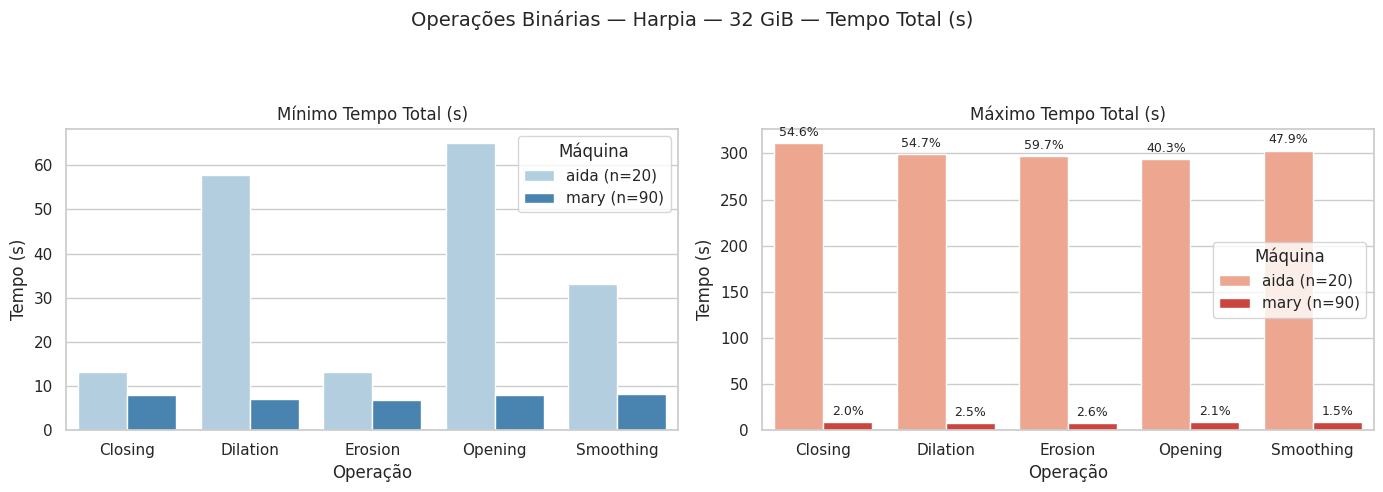

🔧 Plotting: Operações Morfológicas Binárias, Framework: cuCIM, Size: 1 GiB
Imagem salva em: comp_report_plots/min_max_execution_time_boxplot_cuCIM_Closing 3D binary_1gib.png


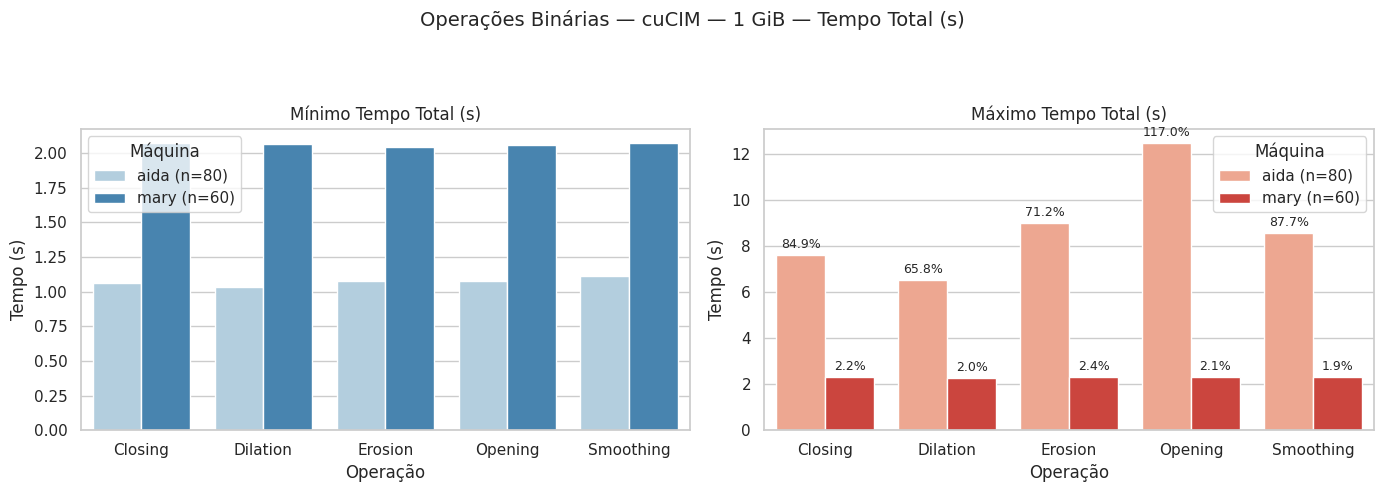

🔧 Plotting: Operações Morfológicas Binárias, Framework: cuCIM, Size: 2 GiB
Imagem salva em: comp_report_plots/min_max_execution_time_boxplot_cuCIM_Closing 3D binary_2gib.png


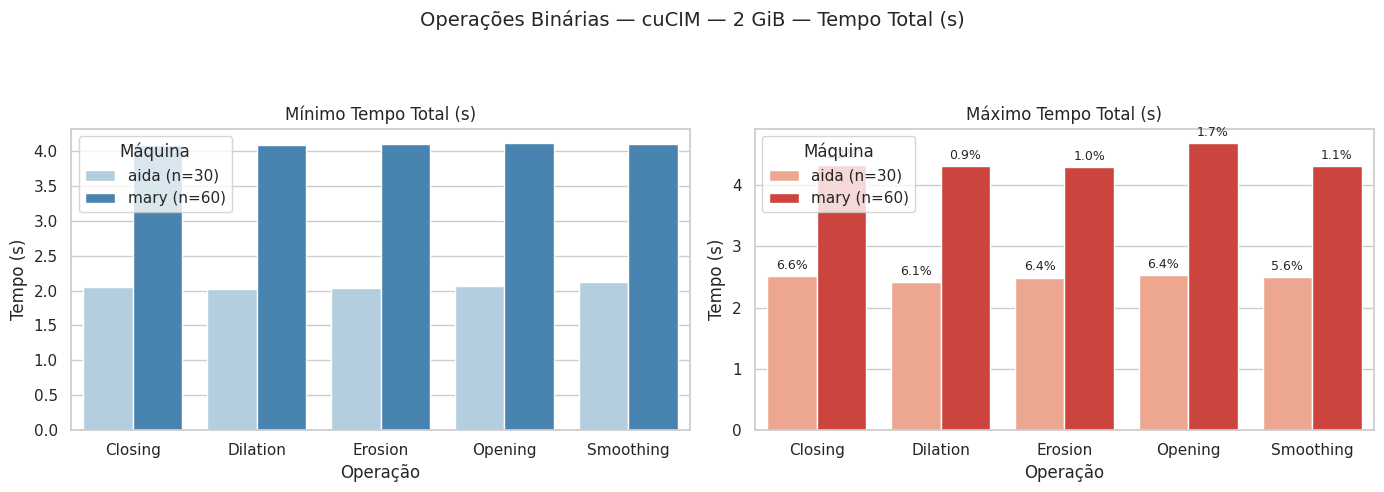

🔧 Plotting: Operações Morfológicas Binárias, Framework: cuCIM, Size: 3 GiB
⚠️ Sem dados para: cuCIM, 3 GiB
🔧 Plotting: Operações Morfológicas Binárias, Framework: cuCIM, Size: 4 GiB
Imagem salva em: comp_report_plots/min_max_execution_time_boxplot_cuCIM_Closing 3D binary_4gib.png


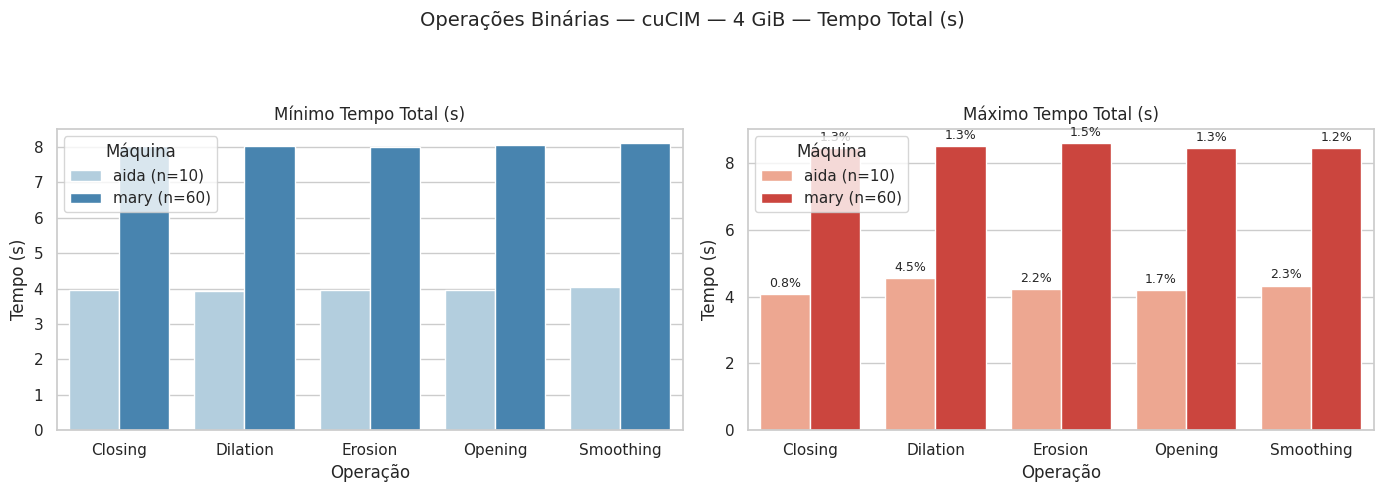

🔧 Plotting: Operações Morfológicas Binárias, Framework: cuCIM, Size: 8 GiB
Imagem salva em: comp_report_plots/min_max_execution_time_boxplot_cuCIM_Closing 3D binary_8gib.png


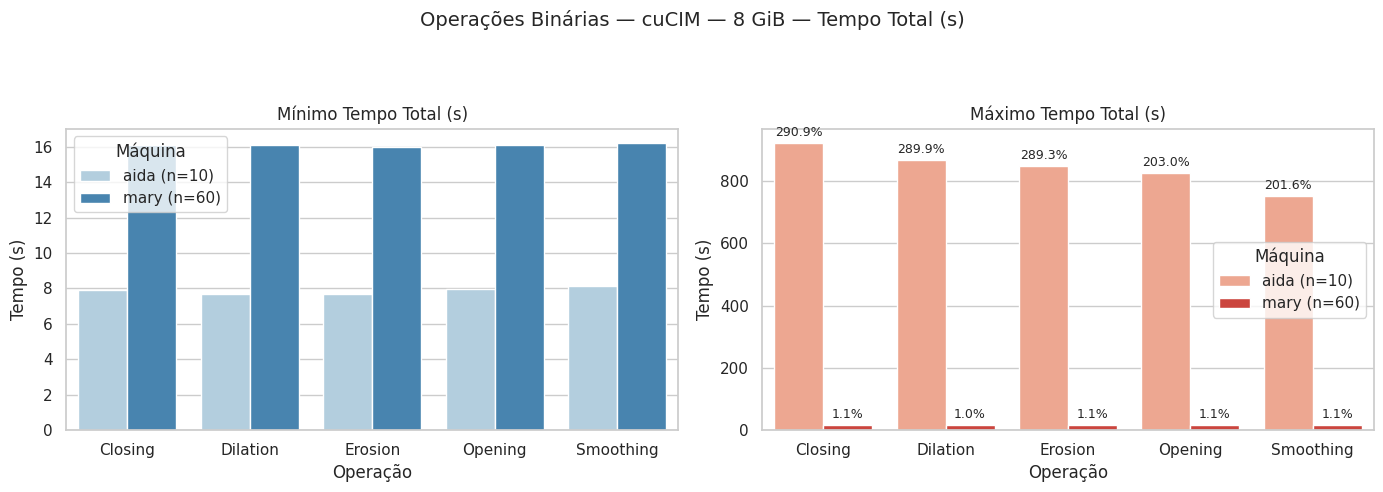

🔧 Plotting: Operações Morfológicas Binárias, Framework: cuCIM, Size: 16 GiB
Imagem salva em: comp_report_plots/min_max_execution_time_boxplot_cuCIM_Closing 3D binary_16gib.png


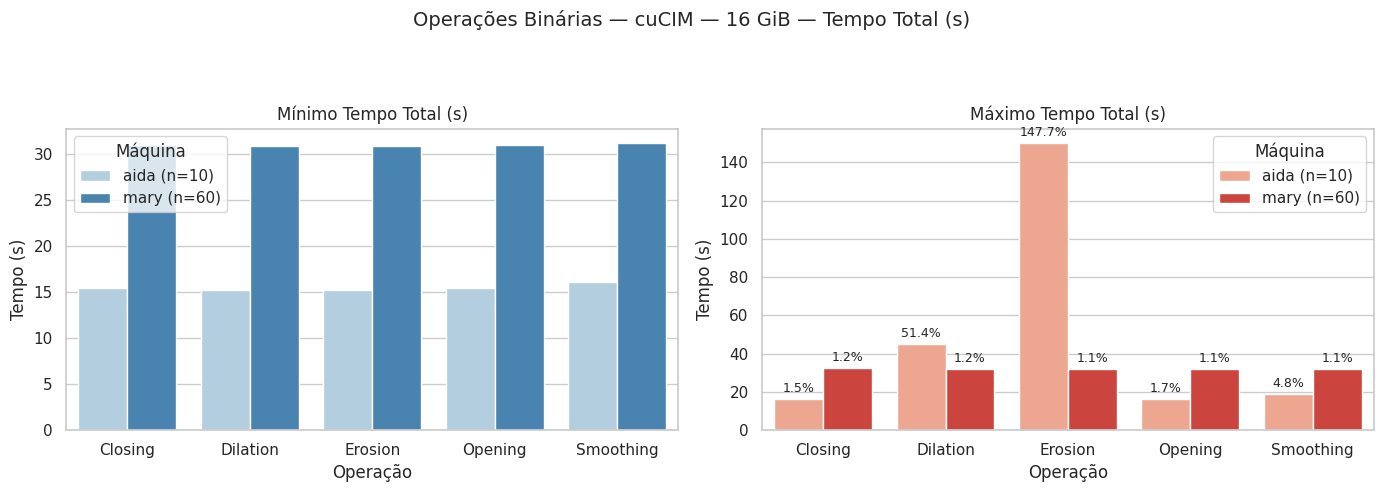

🔧 Plotting: Operações Morfológicas Binárias, Framework: cuCIM, Size: 32 GiB
⚠️ Sem dados para: cuCIM, 32 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: Harpia, Size: 1 GiB
⚠️ Sem dados para: Harpia, 1 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: Harpia, Size: 2 GiB
⚠️ Sem dados para: Harpia, 2 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: Harpia, Size: 3 GiB
⚠️ Sem dados para: Harpia, 3 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: Harpia, Size: 4 GiB
⚠️ Sem dados para: Harpia, 4 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: Harpia, Size: 8 GiB
⚠️ Sem dados para: Harpia, 8 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: Harpia, Size: 16 GiB
⚠️ Sem dados para: Harpia, 16 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: Harpia, Size: 32 GiB
⚠️ Sem dados para: Harpia, 32 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: cuCIM, Size: 1 GiB
Imagem salva em: comp_report_plots/min_ma

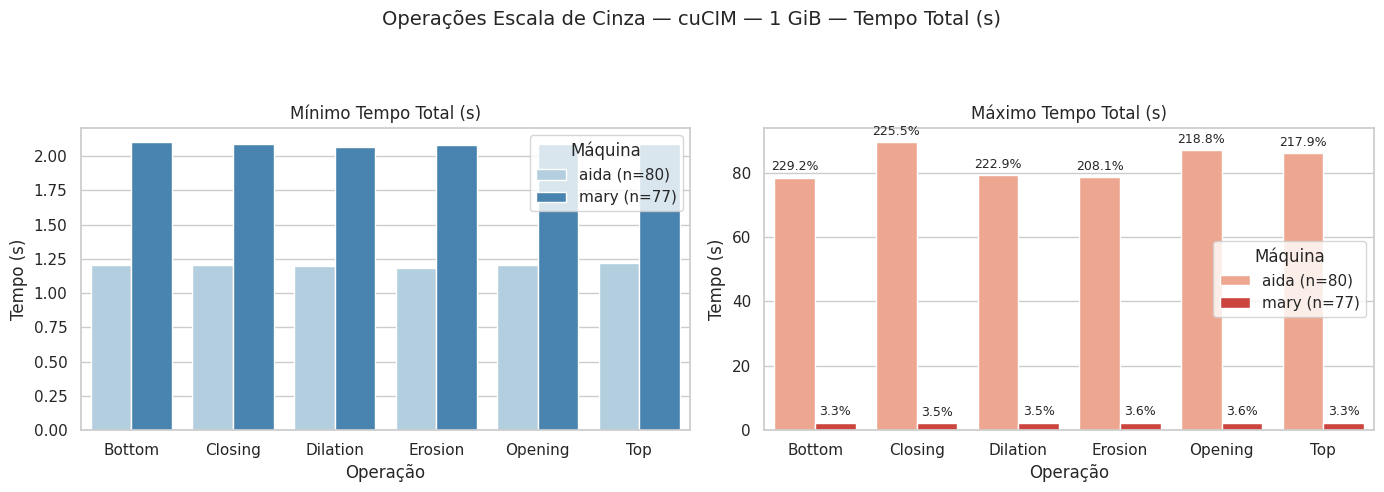

🔧 Plotting: Operações Morfológicas Grayscale, Framework: cuCIM, Size: 2 GiB
Imagem salva em: comp_report_plots/min_max_execution_time_boxplot_cuCIM_Bottom Hat 3D grayscale_2gib.png


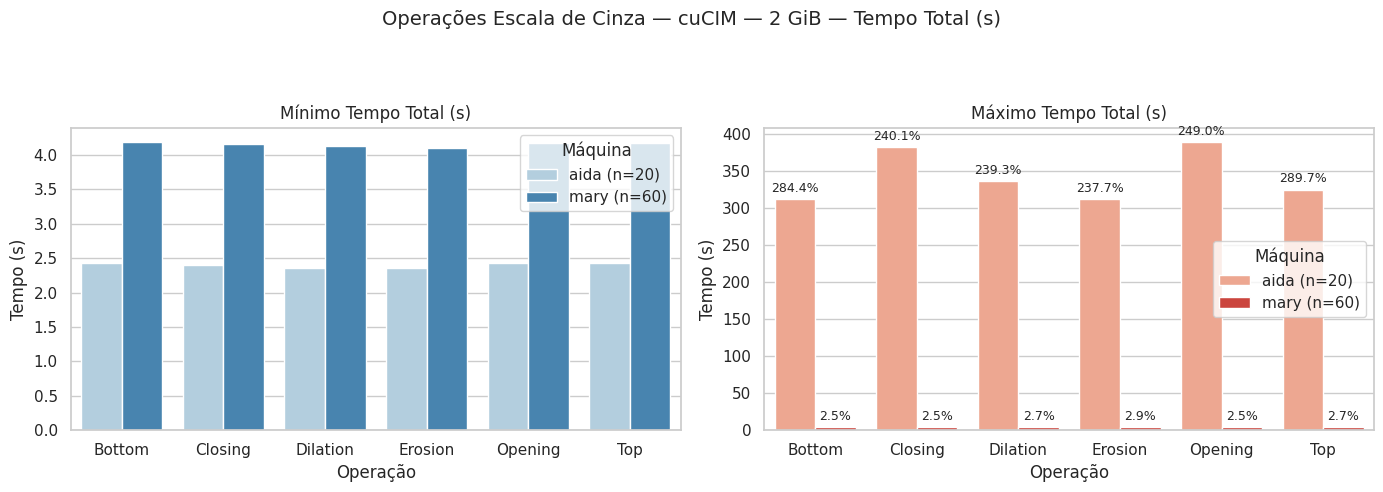

🔧 Plotting: Operações Morfológicas Grayscale, Framework: cuCIM, Size: 3 GiB
⚠️ Sem dados para: cuCIM, 3 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: cuCIM, Size: 4 GiB
⚠️ Sem dados para: cuCIM, 4 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: cuCIM, Size: 8 GiB
⚠️ Sem dados para: cuCIM, 8 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: cuCIM, Size: 16 GiB
⚠️ Sem dados para: cuCIM, 16 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: cuCIM, Size: 32 GiB
⚠️ Sem dados para: cuCIM, 32 GiB
🔧 Plotting: Filtros, Framework: Harpia, Size: 1 GiB
⚠️ Sem dados para: Harpia, 1 GiB
🔧 Plotting: Filtros, Framework: Harpia, Size: 2 GiB
⚠️ Sem dados para: Harpia, 2 GiB
🔧 Plotting: Filtros, Framework: Harpia, Size: 3 GiB
⚠️ Sem dados para: Harpia, 3 GiB
🔧 Plotting: Filtros, Framework: Harpia, Size: 4 GiB
⚠️ Sem dados para: Harpia, 4 GiB
🔧 Plotting: Filtros, Framework: Harpia, Size: 8 GiB
⚠️ Sem dados para: Harpia, 8 GiB
🔧 Plotting: Filtros, Framework:

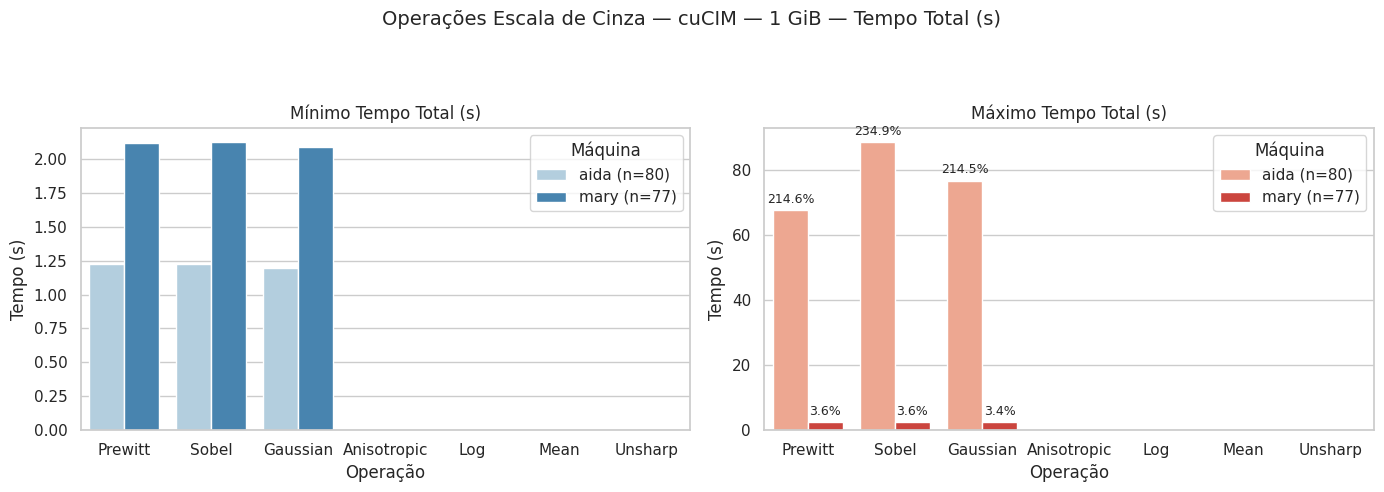

🔧 Plotting: Filtros, Framework: cuCIM, Size: 2 GiB
Imagem salva em: comp_report_plots/min_max_execution_time_boxplot_cuCIM_Prewitt Filter 3D grayscale_2gib.png


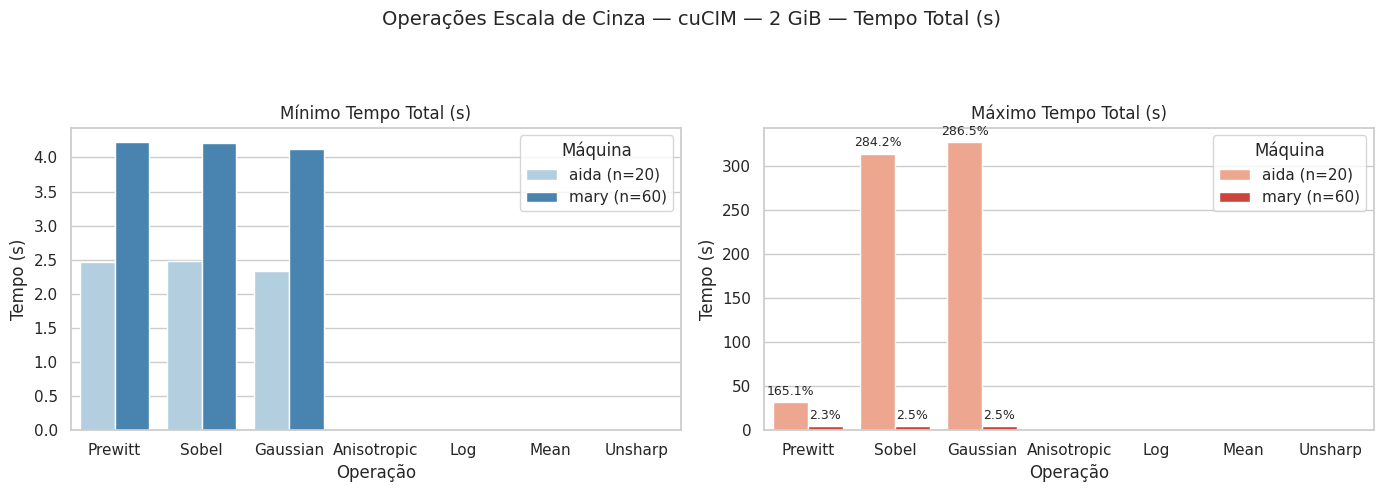

🔧 Plotting: Filtros, Framework: cuCIM, Size: 3 GiB
⚠️ Sem dados para: cuCIM, 3 GiB
🔧 Plotting: Filtros, Framework: cuCIM, Size: 4 GiB
⚠️ Sem dados para: cuCIM, 4 GiB
🔧 Plotting: Filtros, Framework: cuCIM, Size: 8 GiB
⚠️ Sem dados para: cuCIM, 8 GiB
🔧 Plotting: Filtros, Framework: cuCIM, Size: 16 GiB
⚠️ Sem dados para: cuCIM, 16 GiB
🔧 Plotting: Filtros, Framework: cuCIM, Size: 32 GiB
⚠️ Sem dados para: cuCIM, 32 GiB
🔧 Plotting: Threshold, Framework: Harpia, Size: 1 GiB
⚠️ Sem dados para: Harpia, 1 GiB
🔧 Plotting: Threshold, Framework: Harpia, Size: 2 GiB
⚠️ Sem dados para: Harpia, 2 GiB
🔧 Plotting: Threshold, Framework: Harpia, Size: 3 GiB
⚠️ Sem dados para: Harpia, 3 GiB
🔧 Plotting: Threshold, Framework: Harpia, Size: 4 GiB
⚠️ Sem dados para: Harpia, 4 GiB
🔧 Plotting: Threshold, Framework: Harpia, Size: 8 GiB
⚠️ Sem dados para: Harpia, 8 GiB
🔧 Plotting: Threshold, Framework: Harpia, Size: 16 GiB
⚠️ Sem dados para: Harpia, 16 GiB
🔧 Plotting: Threshold, Framework: Harpia, Size: 32 GiB
⚠️

ValueError: Categorical categories must be unique

In [201]:
image_sizes_gib = [1, 2, 3, 4, 8, 16, 32]
frameworks = ['Harpia', 'cuCIM']

binary_ops = [
    'Closing 3D binary', 'Dilation 3D binary', 'Erosion 3D binary',
    'Opening 3D binary', 'Smoothing 3D binary'
]

grayscale_ops = [
    'Bottom Hat 3D grayscale', 'Closing 3D grayscale', 'Dilation 3D grayscale',
    'Erosion 3D grayscale', 'Opening 3D grayscale', 'Top Hat 3D grayscale'
]

filter_ops = [
    'Prewitt Filter 3D grayscale', 'Sobel Filter 3D grayscale', 'Gaussian Filter 3D grayscale',
    'Anisotropic Diffusion Filter 3D grayscale', 'Log Filter 3D grayscale',
    'Mean Filter 3D grayscale', 'Unsharp Mask Filter 3D grayscale'
]

threshold_ops = [
    'Threshold Niblack', 'Threshold Sauvola', 'Threshold Mean'
]

operation_groups = [
    ("Operações Morfológicas Binárias", binary_ops),
    ("Operações Morfológicas Grayscale", grayscale_ops),
    ("Filtros", filter_ops),
    ("Threshold", threshold_ops)
]

for group_name, operations in operation_groups:
    for framework in frameworks:
        for size in image_sizes_gib:
            print(f'🔧 Plotting: {group_name}, Framework: {framework}, Size: {size} GiB')
            plot_min_max_execution_times(
                df=df_aida_mary_filtered,
                summarize_df=df_summary,
                operations=operations,
                framework=framework,
                image_size_gib=size,
                output_dir=output_dir,
                time_column='Total Time (s)'
            )

In [191]:
df_summary.columns

Index(['Machine', 'Framework', 'Operation', 'Image Size (GiB)',
       'Total Time (s)_count', 'Total Time (s)_mean', 'Total Time (s)_std',
       'Memory Time (s)_count', 'Memory Time (s)_mean', 'Memory Time (s)_std',
       'Gpu Time (s)_count', 'Gpu Time (s)_mean', 'Gpu Time (s)_std',
       'Total Time (s)_std_%', 'Memory Time (s)_std_%', 'Gpu Time (s)_std_%'],
      dtype='object')

### Plots - Boxplot Execution Time by Operation

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_memory_gpu_time_by_operation_harpia(df):
    sns.set(style="whitegrid")
    
    time_cols = ['Total Time (s)']
    operations = df['Operation'].unique()

    for op in operations:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        fig.suptitle(f"Memory vs GPU Time for Operation: {op}", fontsize=16)

        op_df = df[df['Operation'] == op]

        for idx, time_col in enumerate(time_cols):
            if time_col in op_df.columns:
                sns.boxplot(
                    data=op_df,
                    x='Machine',
                    y=time_col,
                    hue='Image Size (MiB)',
                    ax=axes[idx]
                )
                axes[idx].set_title(time_col)
                axes[idx].set_xlabel('Machine')
                axes[idx].set_ylabel('Time (s)')
                axes[idx].legend(title='Image Size (MiB)', bbox_to_anchor=(1.05, 1), loc='upper left')
            else:
                axes[idx].set_visible(False)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_memory_gpu_time_by_operation(df):
    sns.set(style="whitegrid")
    
    time_cols = ['Memory Time (s)', 'Gpu Time (s)']
    operations = df['Operation'].unique()

    for op in operations:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        fig.suptitle(f"Memory vs GPU Time for Operation: {op}", fontsize=16)

        op_df = df[df['Operation'] == op]

        for idx, time_col in enumerate(time_cols):
            if time_col in op_df.columns:
                sns.boxplot(
                    data=op_df,
                    x='Machine',
                    y=time_col,
                    hue='Image Size (MiB)',
                    ax=axes[idx]
                )
                axes[idx].set_title(time_col)
                axes[idx].set_xlabel('Machine')
                axes[idx].set_ylabel('Time (s)')
                axes[idx].legend(title='Image Size (MiB)', bbox_to_anchor=(1.05, 1), loc='upper left')
            else:
                axes[idx].set_visible(False)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


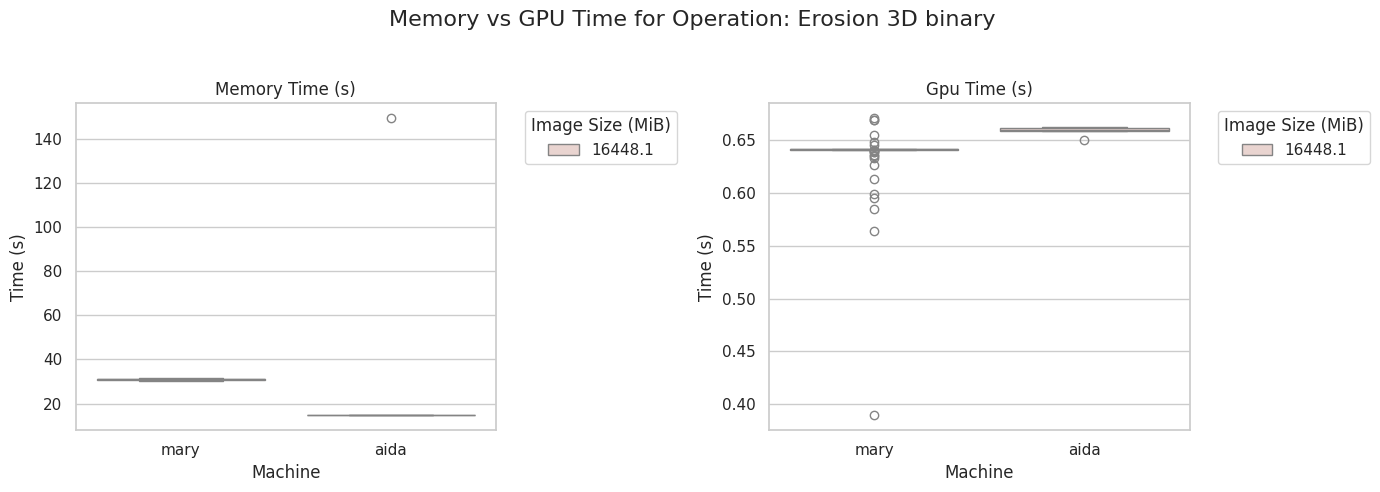

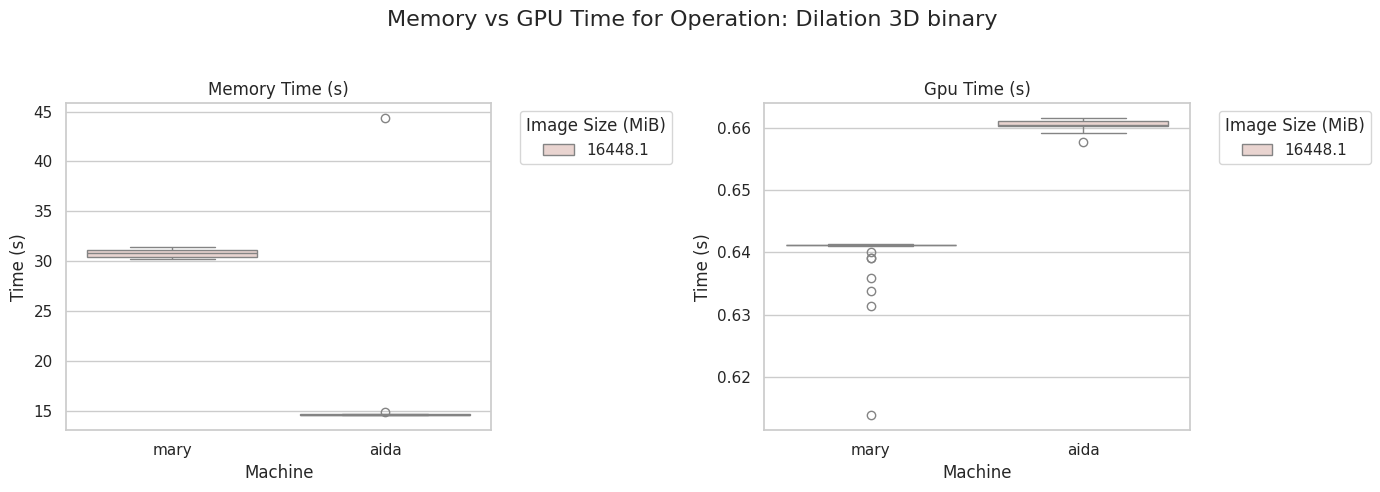

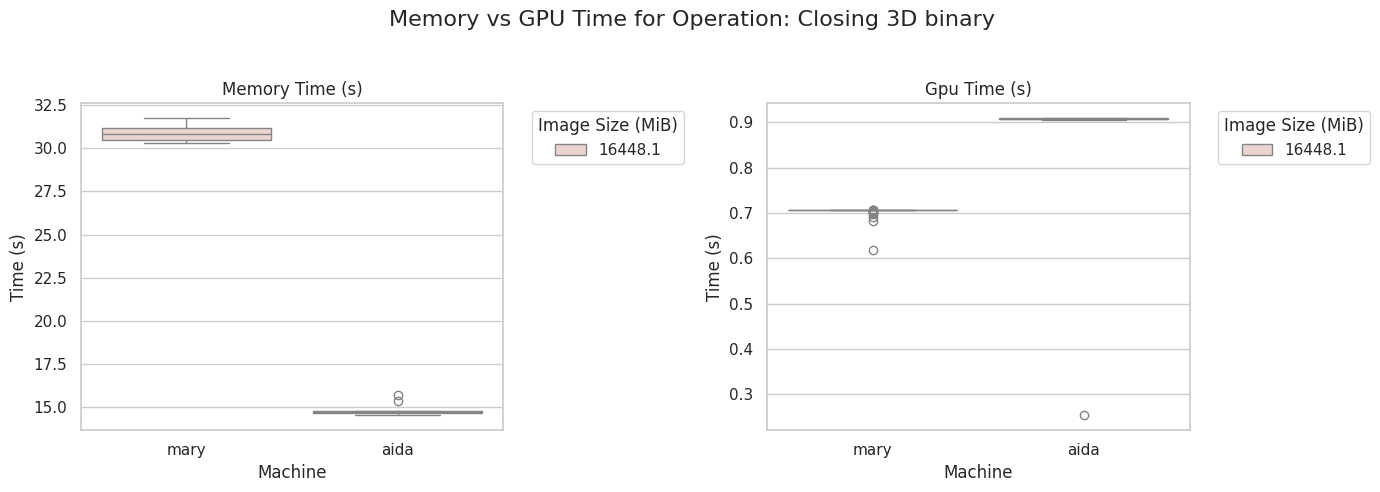

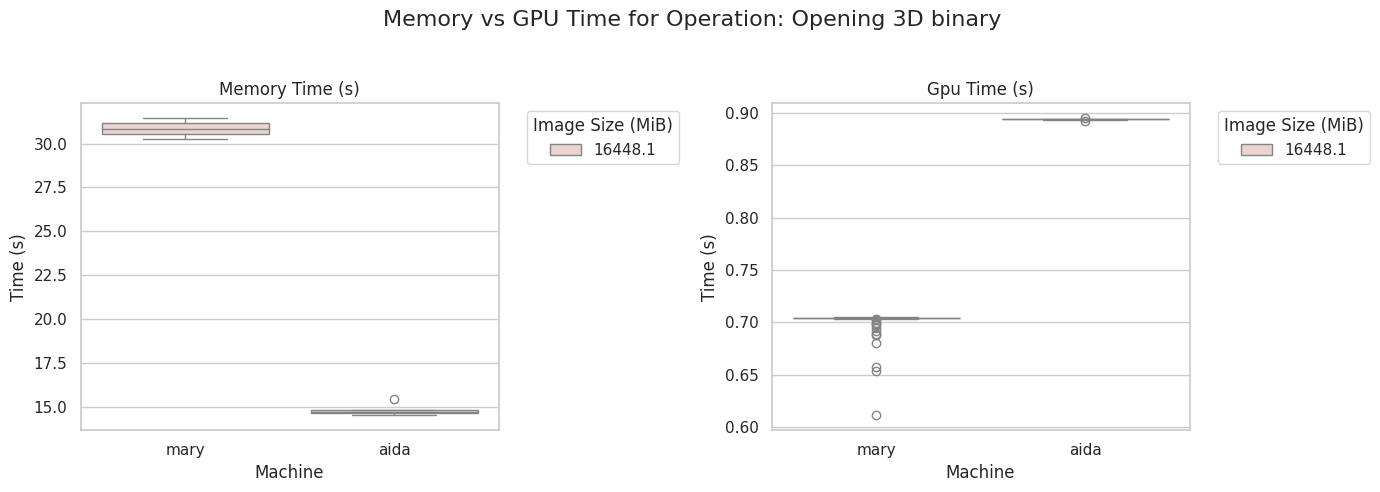

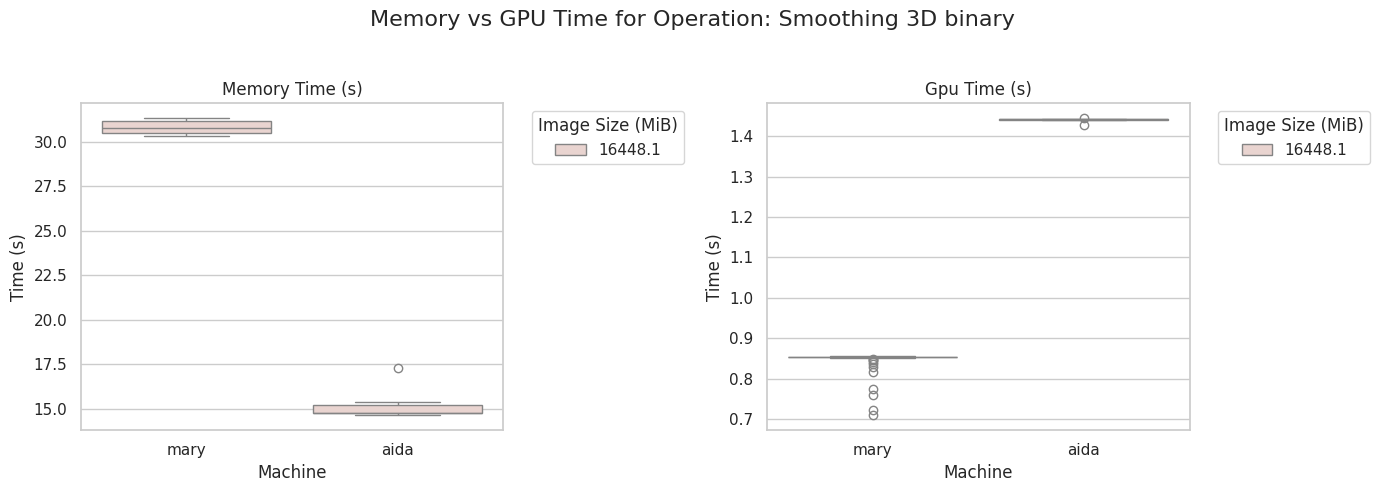

In [25]:
df_plot = df_aida_mary[(df_aida_mary['Framework']=='cuCIM')&(df_aida_mary['Image Size (MiB)']>16000)]
plot_memory_gpu_time_by_operation(df_plot)